# Проект 5. Выбираем авто выгодно 

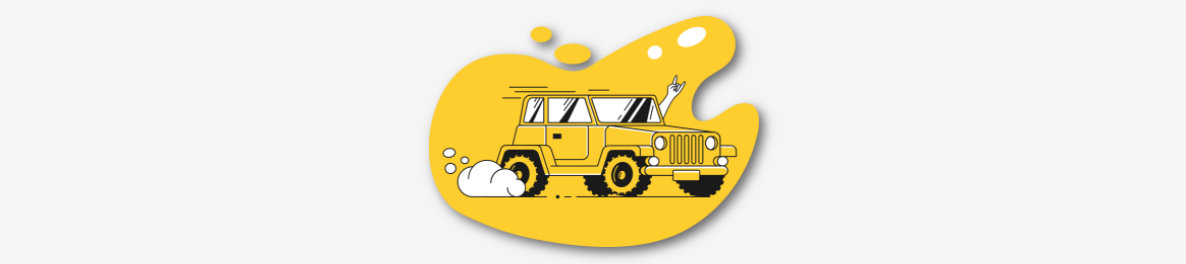

### Цель проекта 

<b>Создание модели на основе данных, собранных из открытых источников, которая будет предсказывать стоимость автомобиля по его характеристикам.</b>

In [23]:
# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split, KFold

In [24]:
import numpy as np
#from catboost import CatBoostRegressor  
from sklearn.preprocessing import LabelEncoder

In [25]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from bs4.dammit import EncodingDetector
import matplotlib.pyplot as plt 

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

#для оценки категориальных переменных
from sklearn.feature_selection import f_classif, mutual_info_classif
from pandas import Series 

In [27]:
from sklearn.linear_model import LogisticRegression # наша модель для классификации
from sklearn.preprocessing import PolynomialFeatures #для создания полиномиальных признаков

from itertools import combinations #для теста Стьюдента
from scipy.stats import ttest_ind #для теста Стьюдента

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

from sklearn.tree import DecisionTreeRegressor #решающие деревья в задачи регрессии
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler

In [28]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor

In [29]:
def get_stat_dif(column, data):
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'price'], 
                        data.loc[data.loc[:, column] == comb[1], 'price']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
        else:
            return column
            break

In [30]:
#Функция для анализа квантилей и выбросов
def func_quantile(df, col):   
    
    IQR = df[col].quantile(q=0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
    # Подсчитаем количество выбросов
    print("Количество выбросов в столбце",col,":",df[df[col]<perc25 - 1.5*IQR][col].count() + df[df[col]>perc75 + 1.5*IQR][col].count())
    df[col].loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 20, label = 'IQR')
    plt.legend()  

In [31]:
#Функция для заполнения выбросов ближайшим квантилем
def filling_quantile(df, col, change_quant): #quant=0.25 или 0.75
    IQR = df[col].quantile(q=0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    high_border = perc75 + 1.5*IQR
    low_border = perc25 - 1.5*IQR
    if change_quant == 0.75:
        df[col] = df[col].apply(lambda x: high_border if x>high_border else x)
    elif change_quant == 0.25:
        df[col] = df[col].apply(lambda x: low_border if x<low_border else x)
    else:
        print('Значение квантиля должно быть 0.25 или 0.75 :)')

## ПАРСИНГ САЙТА AUTO.RU

In [14]:
lists1 = []
lists = []
for z in range(1,100):
    url = 'https://auto.ru/cars/honda/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_honda_car = df_lists_all_new.join(df_splitted)

In [16]:
df_honda_car.to_csv('df_honda_car.csv')

In [ ]:
#Выкачаем AUDI

In [17]:
lists1 = []
lists = []
for z in range(1,100):
    url = 'https://auto.ru/cars/audi/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_audi_car = df_lists_all_new.join(df_splitted)

In [18]:
df_audi_car.to_csv('df_audi_car.csv')

In [20]:
lists1 = []
lists = []
for z in range(1,100):
    url = 'https://auto.ru/cars/skoda/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_skoda_car = df_lists_all_new.join(df_splitted)

In [22]:
df_skoda_car.to_csv('df_audi_car.csv')

In [23]:
lists1 = []
lists = []
for z in range(1,100):
    url = 'https://auto.ru/cars/mercedes/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_merc_car = df_lists_all_new.join(df_splitted)
df_merc_car.to_csv('df_merc_car.csv')
print("merc закачался")


##################################
lists1 = []
lists = []
for z in range(1,100):
    url = 'https://auto.ru/cars/toyota/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_toyota_car = df_lists_all_new.join(df_splitted)
df_toyota_car.to_csv('df_toyota_car.csv')
print("toyota закачался")


##################################
lists1 = []
lists = []
for z in range(1,100):
    url = 'https://auto.ru/cars/lexus/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_lexus_car = df_lists_all_new.join(df_splitted)
df_lexus_car.to_csv('df_lexus_car.csv')
print("lexus закачался")




merc закачался
toyota закачался
lexus закачался


AttributeError: 'NoneType' object has no attribute 'split'

In [24]:
##################################
lists1 = []
lists = []
for z in range(1,99):
    url = 'https://auto.ru/cars/volkswagen/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_volkswagen_car = df_lists_all_new.join(df_splitted)
df_volkswagen_car.to_csv('df_volkswagen_car.csv')
print("volkswagen закачался")


##################################
lists1 = []
lists = []
for z in range(1,100):
    url = 'https://auto.ru/cars/mitsubishi/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_mitsubishi_car = df_lists_all_new.join(df_splitted)
df_mitsubishi_car.to_csv('df_mitsubishi_car.csv')
print("mitsubishi закачался")

##################################
lists1 = []
lists = []
for z in range(1,80):
    url = 'https://auto.ru/cars/volvo/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_volvo_car = df_lists_all_new.join(df_splitted)
df_volvo_car.to_csv('df_volvo_car.csv')
print("volvo закачался")


##################################
lists1 = []
lists = []
for z in range(1,100):
    url = 'https://auto.ru/cars/bmw/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_bmw_car = df_lists_all_new.join(df_splitted)
df_bmw_car.to_csv('df_bmw_car.csv')
print("bmw закачался")

##################################
lists1 = []
lists = []
for z in range(1,100):
    url = 'https://auto.ru/cars/nissan/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_nissan_car = df_lists_all_new.join(df_splitted)
df_nissan_car.to_csv('df_nissan_car.csv')
print("nissan закачался")



volkswagen закачался
mitsubishi закачался
volvo закачался
bmw закачался
nissan закачался


AttributeError: 'NoneType' object has no attribute 'split'

In [25]:
##################################
lists1 = []
lists = []
for z in range(1,50):
    url = 'https://auto.ru/cars/infiniti/all/?output_type=table'
    url = url+'&page='+str(z)
    
    response = requests.get(url)  
    http_encoding = response.encoding if 'charset' in response.headers.get('content-type', '').lower() else None
    html_encoding = EncodingDetector.find_declared_encoding(response.content, is_html=True)
    encoding = html_encoding or http_encoding
    soup2 = BeautifulSoup(response.content, 'lxml', from_encoding=encoding)   
  
    block3 = soup2.find_all('script',type="application/ld+json")
    lists = [j.text for j in block3]
    lists1.append(lists[1:-2])
    df_lists = pd.DataFrame(lists1).T
    
    #все столбцы сливаю в один, друг под другом. Каждый столбец был страницей со списком из 37 машин 
df_lists_all = pd.DataFrame()
for col in df_lists.columns:
    df_lists_all = pd.concat([df_lists_all,df_lists[col]],axis=0)

df_splitted = pd.DataFrame([i.split(',') for i in df_lists_all[0]])
df_lists_all.columns = ['all']
df_lists_all_new = df_lists_all.reset_index()
df_infiniti_car = df_lists_all_new.join(df_splitted)
df_infiniti_car.to_csv('df_infiniti_car.csv')
print("все закачалось")

все закачалось


In [ ]:
'''Теперь соединим все машины'''

In [26]:
df_honda_audi = df_honda_car.append(df_audi_car, sort=False).reset_index(drop=True)

In [28]:
df_honda_audi.to_excel('./df_honda_audi.xlsx')

In [29]:
df_honda_audi_skoda = df_honda_audi.append(df_skoda_car, sort=False).reset_index(drop=True)

In [30]:
df_honda_audi_skoda_merc = df_honda_audi_skoda.append(df_merc_car, sort=False).reset_index(drop=True)

In [31]:
df_honda_audi_skoda_merc_toyota = df_honda_audi_skoda_merc.append(df_toyota_car, sort=False).reset_index(drop=True)

In [33]:
df_honda_audi_skoda_merc_toyota_lexus = df_honda_audi_skoda_merc_toyota.append(df_lexus_car, sort=False).reset_index(drop=True)

In [34]:
df_h_a_s_m_t_l_v = df_honda_audi_skoda_merc_toyota_lexus.append(df_volkswagen_car, sort=False).reset_index(drop=True)

In [36]:
df_h_a_s_m_t_l_v_m = df_h_a_s_m_t_l_v.append(df_mitsubishi_car, sort=False).reset_index(drop=True)

In [37]:
df_h_a_s_m_t_l_v_m_v = df_h_a_s_m_t_l_v_m.append(df_volvo_car, sort=False).reset_index(drop=True)

In [38]:
df_h_a_s_m_t_l_v_m_v_b = df_h_a_s_m_t_l_v_m_v.append(df_bmw_car, sort=False).reset_index(drop=True)

In [39]:
df_h_a_s_m_t_l_v_m_v_b_n = df_h_a_s_m_t_l_v_m_v_b.append(df_nissan_car, sort=False).reset_index(drop=True)

In [40]:
df_h_a_s_m_t_l_v_m_v_b_n_i = df_h_a_s_m_t_l_v_m_v_b_n.append(df_infiniti_car, sort=False).reset_index(drop=True)

In [42]:
df_h_a_s_m_t_l_v_m_v_b_n_i.to_excel('./All_brand_cars.xlsx')

In [43]:
df_h_a_s_m_t_l_v_m_v_b_n_i

,index,all,0,1,2,3,4,5,6,7,...,174,175,176,177,178,179,180,181,182,183
0,0,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Stream II Рестайлинг""","""bodyType"":""компактвэн""","""brand"":""HONDA""","""color"":""серый""","""fuelType"":""бензин""","""image"":{""@context"":""https://schema.org""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Stepwgn V""","""bodyType"":""минивэн""","""brand"":""HONDA""","""color"":""серый""","""fuelType"":""бензин""","""image"":{""@context"":""https://schema.org""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Accord VIII""","""bodyType"":""седан""","""brand"":""HONDA""","""color"":""серый""","""fuelType"":""бензин""","""image"":{""@context"":""https://schema.org""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda CR-V I""","""bodyType"":""внедорожник 5 дв.""","""brand"":""HONDA""","""color"":""зелёный""","""fuelType"":""бензин""","""image"":{""@context"":""https://schema.org""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Accord VI""","""bodyType"":""седан""","""brand"":""HONDA""","""color"":""синий""","""fuelType"":""бензин""","""image"":{""@context"":""https://schema.org""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41324,32,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti EX EX35 I (J50)""","""bodyType"":""внедорожник 5 дв.""","""brand"":""INFINITI""","""color"":""чёрный""","""fuelType"":""бензин""","""image"":{""@context"":""https://schema.org""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41325,33,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti M M35 III""","""bodyType"":""седан""","""brand"":""INFINITI""","""color"":""серый""","""fuelType"":""бензин""","""image"":{""@context"":""https://schema.org""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41326,34,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti G G35 IV""","""bodyType"":""седан""","""brand"":""INFINITI""","""color"":""серый""","""fuelType"":""бензин""","""image"":{""@context"":""https://schema.org""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41327,35,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti G G35 IV""","""bodyType"":""седан""","""brand"":""INFINITI""","""color"":""чёрный""","""fuelType"":""бензин""","""image"":{""@context"":""https://schema.org""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
df_h_a_s_m_t_l_v_m_v_b_n_i.to_csv('./All_brand_cars.csv')

# Часть 2. Обработка спарсенных данных

In [1]:
import pandas as pd
df_train = pd.read_csv('./All_brand_cars.csv')
df_train

c:\users\valer\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,index,all,0,1,2,3,4,5,6,...,174,175,176,177,178,179,180,181,182,183
0,0,0,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Stream II Рестайлинг""","""bodyType"":""компактвэн""","""brand"":""HONDA""","""color"":""серый""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Stepwgn V""","""bodyType"":""минивэн""","""brand"":""HONDA""","""color"":""серый""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Accord VIII""","""bodyType"":""седан""","""brand"":""HONDA""","""color"":""серый""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda CR-V I""","""bodyType"":""внедорожник 5 дв.""","""brand"":""HONDA""","""color"":""зелёный""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Accord VI""","""bodyType"":""седан""","""brand"":""HONDA""","""color"":""синий""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41324,41324,32,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti EX EX35 I (J50)""","""bodyType"":""внедорожник 5 дв.""","""brand"":""INFINITI""","""color"":""чёрный""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41325,41325,33,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti M M35 III""","""bodyType"":""седан""","""brand"":""INFINITI""","""color"":""серый""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41326,41326,34,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti G G35 IV""","""bodyType"":""седан""","""brand"":""INFINITI""","""color"":""серый""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41327,41327,35,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti G G35 IV""","""bodyType"":""седан""","""brand"":""INFINITI""","""color"":""чёрный""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
import pandas as pd
df_test = pd.read_csv('test.csv')

In [27]:
len(df_test.columns)

32

In [26]:
#Посмотрим на колонки в тестовых данных
df_test.columns.to_list()

['bodyType',
 'brand',
 'car_url',
 'color',
 'complectation_dict',
 'description',
 'engineDisplacement',
 'enginePower',
 'equipment_dict',
 'fuelType',
 'image',
 'mileage',
 'modelDate',
 'model_info',
 'model_name',
 'name',
 'numberOfDoors',
 'parsing_unixtime',
 'priceCurrency',
 'productionDate',
 'sell_id',
 'super_gen',
 'vehicleConfiguration',
 'vehicleTransmission',
 'vendor',
 'Владельцы',
 'Владение',
 'ПТС',
 'Привод',
 'Руль',
 'Состояние',
 'Таможня']

In [162]:
for i in df_test.columns:
    print(i)
    print(df_test[i].value_counts())
    print('-----------')

bodyType
седан                      13147
внедорожник 5 дв.          12228
лифтбек                     2232
хэтчбек 5 дв.               2124
универсал 5 дв.             1276
минивэн                      995
купе                         824
компактвэн                   489
хэтчбек 3 дв.                485
пикап двойная кабина         280
купе-хардтоп                 158
внедорожник 3 дв.            115
родстер                       99
фургон                        97
кабриолет                     90
седан-хардтоп                 12
микровэн                       7
лимузин                        6
седан 2 дв.                    6
пикап одинарная кабина         5
пикап полуторная кабина        5
внедорожник открытый           3
тарга                          2
фастбек                        1
Name: bodyType, dtype: int64
-----------
brand
BMW           4473
VOLKSWAGEN    4404
NISSAN        4393
MERCEDES      4180
TOYOTA        3913
AUDI          3421
MITSUBISHI    2843
SKODA         2741


2.0 LTR    7391
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
2.5 LTR    2477
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
1.5 LTR     725
1.2 LTR     485
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
2.1 LTR     271
3.7 LTR     242
2.2 LTR     236
4.2 LTR     228
1.9 LTR     221
2.3 LTR     203
2.7 LTR     189
3.6 LTR     183
5.6 LTR     170
5.0 LTR     158
5.7 LTR     135
2.9 LTR     131
4.6 LTR     108
3.1 LTR      88
4.8 LTR      84
1.7 LTR      59
1.0 LTR      57
3.8 LTR      57
 LTR         55
2.6 LTR      55
0.7 LTR      53
6.0 LTR      53
3.3 LTR      44
3.4 LTR      36
4.1 LTR      35
4.3 LTR      32
5.4 LTR      31
6.2 LTR      28
5.2 LTR      12
5.9 LTR      12
6.3 LTR       8
5.8 LTR       7
6.6 LTR       6
1.1 LTR       4
4.9 LTR       4
3.9 LTR       1
5.3 LTR       1
Name: engineDisplacement, dtype: int64
-----------
enginePower
249 N12    1708
150 N12    1699
110 N12    1039
170 N12  

-----------
Таможня
Растаможен    34686
Name: Таможня, dtype: int64
-----------


In [3]:
df_train['2'] = df_train['2'].apply(lambda x: str(x).replace('"name":',''))

In [4]:
df_train['3'] = df_train['3'].apply(lambda x: str(x).replace('"bodyType":',''))
df_train['4'] = df_train['4'].apply(lambda x: str(x).replace('"brand":',''))
df_train['5'] = df_train['5'].apply(lambda x: str(x).replace('"color":',''))
df_train['6'] = df_train['6'].apply(lambda x: str(x).replace('"fuelType":',''))

In [5]:
df_train['14'] = df_train['14'].apply(lambda x: str(x).replace('"modelDate":',''))
df_train['15'] = df_train['15'].apply(lambda x: str(x).replace('"description"',''))

In [6]:
df_train.head()

,Unnamed: 0,index,all,0,1,2,3,4,5,6,...,174,175,176,177,178,179,180,181,182,183
0,0,0,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""Honda Stream II Рестайлинг""","""компактвэн""","""HONDA""","""серый""","""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""Honda Stepwgn V""","""минивэн""","""HONDA""","""серый""","""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""Honda Accord VIII""","""седан""","""HONDA""","""серый""","""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""Honda CR-V I""","""внедорожник 5 дв.""","""HONDA""","""зелёный""","""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""Honda Accord VI""","""седан""","""HONDA""","""синий""","""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df_train = df_train.rename(columns= {'2': 'model_name', '4': 'brand'})

In [8]:
df_train = df_train.rename(columns= {'3': 'bodyType', '5': 'color','6':'fuelType'})

In [9]:
df_train = df_train.rename(columns= {'10': 'car_url'})

In [10]:
df_train = df_train.rename(columns= {'14': 'modelDate'})

In [11]:
df_train['bodyType'] = df_train['bodyType'].apply(lambda x: str(x).replace('"',''))

In [13]:
df_train['model_name'] = df_train['model_name'].apply(lambda x: str(x).replace('"',''))

In [174]:
#########################################################

In [14]:
df_train['13'][0]

'"name":"Honda Stream II Рестайлинг серого цвета"}'

In [11]:
#универсальная функция для поиска нужных параметров в колонке all, чтобы вытащить их в отдельный столбец
def find_word(row,step,word):
    result = row.find(word)
    return row[result:result+step]

In [16]:
#Применим функцию и вытащим нужные параметры в колонке all
df_train['enginePower'] = df_train['all'].apply(lambda row: find_word(row,22,'enginePower'))

In [17]:
df_train['enginePower'] = df_train['enginePower'].apply(lambda x: str(x).replace('enginePower":"',''))

In [18]:
df_train['enginePower'] = df_train['enginePower'].apply(lambda x: str(x).replace('"',''))

In [19]:
df_train['enginePower'] = df_train['enginePower'].apply(lambda x: str(x).replace(',',''))

In [20]:
df_train['price'] = df_train['all'].apply(lambda row: find_word(row,15,'цене'))

In [21]:
df_train['price'] = df_train['price'].apply(lambda x: str(x).replace('цене',''))
df_train['price'] = df_train['price'].apply(lambda x: str(x).replace(' ру',''))
df_train['price'] = df_train['price'].apply(lambda x: str(x).replace(' ',''))

In [22]:
df_train['price'] = df_train['price'].apply(lambda x: str(x).replace('ру',''))

In [23]:
#вытащу vehicleTransmission из колонки all
df_train['vehicleTransmission'] = df_train['all'].apply(lambda row: find_word(row,38,'vehicleTransmission'))

In [24]:
#очистим от лишнего
df_train['vehicleTransmission'] = df_train['vehicleTransmission'].apply(lambda x: str(x).replace('vehicleTransmission":"',''))

In [25]:
df_train['vehicleTransmission'] = df_train['vehicleTransmission'].apply(lambda x: str(x).replace(',"vehic":"',''))

In [26]:
df_train['vehicleTransmission'] = df_train['vehicleTransmission'].apply(lambda x: str(x).replace('"',''))
df_train['vehicleTransmission'] = df_train['vehicleTransmission'].apply(lambda x: str(x).replace(',',''))

In [27]:
df_train['vehicleTransmission'] = df_train['vehicleTransmission'].apply(lambda x: str(x).replace('v',''))
df_train['vehicleTransmission'] = df_train['vehicleTransmission'].apply(lambda x: str(x).replace('ehic',''))

In [28]:
df_train['engineDisplacement'] = df_train['all'].apply(lambda row: find_word(row,28,'engineDisplacement'))    

In [29]:
df_train['engineDisplacement'] = df_train['engineDisplacement'].apply(lambda x: str(x).replace('engineDisplacement":"',''))

In [30]:
df_train['name'] = df_train['all'].apply(lambda row: find_word(row,36,'EngineSpecification","name":')) 

In [31]:
df_train['name'] = df_train['name'].apply(lambda x: str(x).replace('EngineSpecification","name":"',''))
df_train['name'] = df_train['name'].apply(lambda x: str(x).replace('"',''))

In [32]:
df_train['numberOfDoors'] = df_train['all'].apply(lambda row: find_word(row,16,'numberOfDoors'))
df_train['numberOfDoors'] = df_train['numberOfDoors'].apply(lambda x: str(x).replace('"',''))

In [33]:
df_train['numberOfDoors'] = df_train['numberOfDoors'].apply(lambda x: str(x).replace('numberOfDoors:',''))

In [34]:
df_train['priceCurrency'] = df_train['all'].apply(lambda row: find_word(row,19,'priceCurrency'))
df_train['priceCurrency'] = df_train['priceCurrency'].apply(lambda x: str(x).replace('priceCurrency":"',''))

In [35]:
df_train['productionDate'] = df_train['all'].apply(lambda row: find_word(row,20,'productionDate'))
df_train['productionDate'] = df_train['productionDate'].apply(lambda x: str(x).replace('productionDate":',''))

In [36]:
df_train['vehicleConfiguration'] = df_train['all'].apply(lambda row: find_word(row,55,'vehicleConfiguration'))

df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('vehicleConfiguration":"',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace(' "',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('" ',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('"',''))

df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace(',vehicleTrans',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace(',vehicleTra',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace(',v',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace(',',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('n',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('e',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('hicl',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('Tr',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('hi',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('hic',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('mi',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('m',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('c',''))
df_train['vehicleConfiguration'] = df_train['vehicleConfiguration'].apply(lambda x: str(x).replace('T',''))


In [37]:
df_train_clean = df_train.loc[:,['bodyType','brand','car_url','color','engineDisplacement','enginePower','fuelType','model_name','name','modelDate','numberOfDoors','priceCurrency','productionDate','vehicleConfiguration','vehicleTransmission','price']]

In [38]:
df_train_clean['color'] = df_train_clean['color'].apply(lambda x: str(x).replace('"',''))

In [39]:
df_train_clean['brand'] = df_train_clean['brand'].apply(lambda x: str(x).replace('"',''))

In [40]:
df_train_clean['fuelType'] = df_train_clean['fuelType'].apply(lambda x: str(x).replace('"',''))

In [41]:
df_train_clean

,bodyType,brand,car_url,color,engineDisplacement,enginePower,fuelType,model_name,name,modelDate,numberOfDoors,priceCurrency,productionDate,vehicleConfiguration,vehicleTransmission,price
0,компактвэн,HONDA,"""contentUrl"":""https://avatars.mds.yandex.net/g...",серый,1.8 LTR,140 N12,бензин,Honda Stream II Рестайлинг,1.8 AT,2009,5,RUR,2010,COMPACVAN AUOMAIC 1.8,автоматическая,869 000
1,минивэн,HONDA,"""contentUrl"":""https://avatars.mds.yandex.net/g...",серый,1.5 LTR,150 N12,бензин,Honda Stepwgn V,1.5 CVT,2015,5,RUR,2016,MINIVAN VARIAOR 1.5,вариатор,1 450 000
2,седан,HONDA,"""contentUrl"":""https://autoru.naydex.net/U17gb4...",серый,2.0 LTR,156 N12,бензин,Honda Accord VIII,2.0 MT,2007,4,RUR,2008,SEDAN MECHANICAL 2.0,механическая,950 000
3,внедорожник 5 дв.,HONDA,"""contentUrl"":""https://avatars.mds.yandex.net/g...",зелёный,2.0 LTR,128 N12,бензин,Honda CR-V I,2.0 MT,1995,5,RUR,1998,ALLROAD_5_DOORS MECHANICAL 2.0,механическая,290 000
4,седан,HONDA,"""contentUrl"":""https://autoru.naydex.net/U17gb4...",синий,1.9 LTR,136 N12,бензин,Honda Accord VI,1.9 AT,1997,4,RUR,1998,SEDAN AUOMAIC 1.9,автоматическая,260 000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41324,внедорожник 5 дв.,INFINITI,"""contentUrl"":""https://avatars.mds.yandex.net/g...",чёрный,3.5 LTR,302 N12,бензин,Infiniti EX EX35 I (J50),3.5 AT,2007,5,RUR,2008,ALLROAD_5_DOORS AUOMAIC 3.5,автоматическая,950 000
41325,седан,INFINITI,"""contentUrl"":""https://avatars.mds.yandex.net/g...",серый,3.5 LTR,280 N12,бензин,Infiniti M M35 III,3.5 AT,2005,4,RUR,2007,SEDAN AUOMAIC 3.5,автоматическая,680 000
41326,седан,INFINITI,"""contentUrl"":""https://avatars.mds.yandex.net/g...",серый,3.5 LTR,315 N12,бензин,Infiniti G G35 IV,3.5 AT,2006,4,RUR,2007,SEDAN AUOMAIC 3.5,автоматическая,650 000
41327,седан,INFINITI,"""contentUrl"":""https://avatars.mds.yandex.net/g...",чёрный,3.5 LTR,315 N12,бензин,Infiniti G G35 IV,3.5 AT,2006,4,RUR,2008,SEDAN AUOMAIC 3.5,автоматическая,749 999


In [104]:
'''Нужно поменять тип объекта у цен'''
    

In [5]:
df_train_clean['price'][0]

869000.0

In [122]:
df_train_clean['price'][1]

1450000.0

In [58]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41329 entries, 0 to 41328
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            41329 non-null  int64 
 1   bodyType              41329 non-null  object
 2   brand                 41329 non-null  object
 3   car_url               41329 non-null  object
 4   color                 41329 non-null  object
 5   engineDisplacement    41329 non-null  object
 6   enginePower           41329 non-null  object
 7   fuelType              41329 non-null  object
 8   model_name            41329 non-null  object
 9   name                  41329 non-null  object
 10  modelDate             41329 non-null  object
 11  numberOfDoors         41329 non-null  int64 
 12  priceCurrency         41329 non-null  object
 13  productionDate        41329 non-null  int64 
 14  vehicleConfiguration  41329 non-null  object
 15  vehicleTransmission   41329 non-null

In [59]:
#Поменяем тип цены с object на float
df_train_clean['price'] = df_train_clean['price'].apply(lambda x: str(x.replace('\xa0', '')))

In [61]:
df_train_clean['price'] = df_train_clean['price'].apply(lambda x: str(x.replace(' ', '')))

In [62]:
df_train_clean['price'] = df_train_clean['price'].apply(lambda x: str(x.replace('б','')))

In [63]:
df_train_clean['price'] = df_train_clean.loc[:,'price'].astype('float64')

In [64]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41329 entries, 0 to 41328
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            41329 non-null  int64  
 1   bodyType              41329 non-null  object 
 2   brand                 41329 non-null  object 
 3   car_url               41329 non-null  object 
 4   color                 41329 non-null  object 
 5   engineDisplacement    41329 non-null  object 
 6   enginePower           41329 non-null  object 
 7   fuelType              41329 non-null  object 
 8   model_name            41329 non-null  object 
 9   name                  41329 non-null  object 
 10  modelDate             41329 non-null  object 
 11  numberOfDoors         41329 non-null  int64  
 12  priceCurrency         41329 non-null  object 
 13  productionDate        41329 non-null  int64  
 14  vehicleConfiguration  41329 non-null  object 
 15  vehicleTransmission

In [50]:
df_train_clean.to_excel('./df_train_clean.xlsx')

In [55]:
df_train_clean.to_csv('./df_train_clean.csv')

# БЕРЕМ ОЧИЩЕННЫЙ ТРЕЙН

In [13]:
df_train_clean = pd.read_csv('./df_train_clean.csv')

In [14]:
len(df_train_clean.columns)

17

In [15]:
df_train_clean = df_train_clean.drop(['Unnamed: 0','Unnamed: 0.1'], axis = 1)

In [16]:
len(df_train_clean.columns)

15

In [22]:
df_train_clean.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'model_name', 'name', 'modelDate', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'vehicleTransmission',
       'price', 'sample'],
      dtype='object')

In [42]:
#Сравним бренды в трейне и в тесте

In [51]:
train_brand = df_train_clean['brand'].unique()
train_brand

array(['HONDA', 'AUDI', 'SKODA', ' C207)', 'MERCEDES', 'bodyType:седан',
       ' C238)', ' C207) Рестайлинг', 'bodyType:купе',
       ' C238) Рестайлинг', 'bodyType:универсал 5 дв.', 'TOYOTA',
       'bodyType:хэтчбек 5 дв.', 'bodyType:минивэн', ' E50', 'LEXUS',
       'VOLKSWAGEN', 'MITSUBISHI', 'VOLVO', 'BMW', 'bodyType:лифтбек',
       'NISSAN', 'bodyType:внедорожник 5 дв.', 'INFINITI'], dtype=object)

In [52]:
test_brand = df_test['brand'].unique()
test_brand

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [53]:
# Признаки, которые есть в test, но нет в train
[i for i in test_brand if i not in train_brand]

[]

Все нужные бренды в train присутствуют.

In [54]:
# Признаки, которые есть в train, но нет в test
[i for i in train_brand if i not in test_brand]

[' C207)',
 'bodyType:седан',
 ' C238)',
 ' C207) Рестайлинг',
 'bodyType:купе',
 ' C238) Рестайлинг',
 'bodyType:универсал 5 дв.',
 'bodyType:хэтчбек 5 дв.',
 'bodyType:минивэн',
 ' E50',
 'bodyType:лифтбек',
 'bodyType:внедорожник 5 дв.']

In [ ]:
#заменить их

In [6]:
df_train_clean

,Unnamed: 0,Unnamed: 0.1,bodyType,brand,color,engineDisplacement,enginePower,fuelType,model_name,name,modelDate,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,price,sample
0,0,0,компактвэн,HONDA,серый,1.8 LTR,140 N12,бензин,Honda Stream II Рестайлинг,1.8 AT,2009,5,2010,COMPACVAN AUOMAIC 1.8,автоматическая,869000.0,1
1,1,1,минивэн,HONDA,серый,1.5 LTR,150 N12,бензин,Honda Stepwgn V,1.5 CVT,2015,5,2016,MINIVAN VARIAOR 1.5,вариатор,1450000.0,1
2,2,2,седан,HONDA,серый,2.0 LTR,156 N12,бензин,Honda Accord VIII,2.0 MT,2007,4,2008,SEDAN MECHANICAL 2.0,механическая,950000.0,1
3,3,3,внедорожник 5 дв.,HONDA,зелёный,2.0 LTR,128 N12,бензин,Honda CR-V I,2.0 MT,1995,5,1998,ALLROAD_5_DOORS MECHANICAL 2.0,механическая,290000.0,1
4,4,4,седан,HONDA,синий,1.9 LTR,136 N12,бензин,Honda Accord VI,1.9 AT,1997,4,1998,SEDAN AUOMAIC 1.9,автоматическая,260000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41324,41324,41324,внедорожник 5 дв.,INFINITI,чёрный,3.5 LTR,302 N12,бензин,Infiniti EX EX35 I (J50),3.5 AT,2007,5,2008,ALLROAD_5_DOORS AUOMAIC 3.5,автоматическая,950000.0,1
41325,41325,41325,седан,INFINITI,серый,3.5 LTR,280 N12,бензин,Infiniti M M35 III,3.5 AT,2005,4,2007,SEDAN AUOMAIC 3.5,автоматическая,680000.0,1
41326,41326,41326,седан,INFINITI,серый,3.5 LTR,315 N12,бензин,Infiniti G G35 IV,3.5 AT,2006,4,2007,SEDAN AUOMAIC 3.5,автоматическая,650000.0,1
41327,41327,41327,седан,INFINITI,чёрный,3.5 LTR,315 N12,бензин,Infiniti G G35 IV,3.5 AT,2006,4,2008,SEDAN AUOMAIC 3.5,автоматическая,749999.0,1


In [283]:
df_train_clean.loc[:,['productionDate','modelDate','vehicleConfiguration']]

,productionDate,modelDate,vehicleConfiguration
0,2010,2009,MINIVAN ROBO 2.0
1,2011,2009,ALLROAD_5_DOORS AUOMAIC 2.5
2,2005,2000,SEDAN AUOMAIC 1.6
3,2012,2011,SEDAN VARIAOR 3.5
4,2021,2021,ALLROAD_5_DOORS AUOMAIC 1.6
...,...,...,...
27967,2021,2017,ALLROAD_5_DOORS VARIAOR 2.0
27968,2018,2011,LIFBACK MECHANICAL 1.6
27969,2008,2006,WAGON_5_DOORS AUOMAIC 3.1
27970,2014,2012,ALLROAD_5_DOORS VARIAOR 2.0


In [32]:
df_test

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1101369...,коричневый,NaN,Продается BMW 316i в отличном состоянии. Прода...,1.6 LTR,136 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,...,SEDAN AUTOMATIC 1.6,автоматическая,EUROPEAN,3 или более,2 года и 1 месяц,Оригинал,задний,Левый,Не требует ремонта,Растаможен
34682,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101369...,чёрный,NaN,Продаётся отличный автомобиль.,2.0 LTR,190 N12,NaN,дизель,...,SEDAN AUTOMATIC 2.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
34683,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101364...,серый,NaN,Хорошее состояние,2.5 LTR,170 N12,NaN,бензин,...,SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,3 или более,NaN,Дубликат,задний,Левый,Не требует ремонта,Растаможен
34684,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x1/11013625...,коричневый,"{""id"":""6336008"",""name"":""xDrive20d Локальная сб...",Автомобиль в идеальном состоянии . Куплен новы...,2.0 LTR,184 N12,"{""engine-proof"":true,""esp"":true,""start-stop-fu...",дизель,...,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен


In [17]:
df_test_clean = df_test.copy()
df_test_clean = df_test_clean.drop(['complectation_dict','description','equipment_dict','mileage', 'model_info', 'parsing_unixtime', 'super_gen', 'vendor', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня','car_url','priceCurrency'], axis = 1)

In [18]:
len(df_test_clean.columns)

15

In [19]:
df_test_clean.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'image', 'modelDate', 'model_name', 'name', 'numberOfDoors',
       'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission'],
      dtype='object')

In [20]:
df_train_clean.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'model_name', 'name', 'modelDate', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'vehicleTransmission',
       'price', 'sample'],
      dtype='object')

In [21]:
df_train_clean['sample'] = 1 # помечаем где у нас трейн
df_test_clean['sample'] = 0 # помечаем где у нас тест
df_test_clean['price'] = 0 # в тесте у нас нет цен, мы ее должны предсказать, по этому пока просто заполняем нулями

data = df_test_clean.append(df_train_clean, sort=False).reset_index(drop=True) # объединяем

In [22]:
data.to_csv('./data.csv')
data.to_excel('./data.xlsx')

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76015 entries, 0 to 76014
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              76015 non-null  object 
 1   brand                 76015 non-null  object 
 2   color                 76015 non-null  object 
 3   engineDisplacement    76015 non-null  object 
 4   enginePower           76015 non-null  object 
 5   fuelType              76015 non-null  object 
 6   image                 34686 non-null  object 
 7   modelDate             76015 non-null  object 
 8   model_name            76015 non-null  object 
 9   name                  76015 non-null  object 
 10  numberOfDoors         76015 non-null  int64  
 11  productionDate        76015 non-null  int64  
 12  sell_id               34686 non-null  float64
 13  vehicleConfiguration  76015 non-null  object 
 14  vehicleTransmission   76015 non-null  object 
 15  sample             

In [42]:
model_columns = ['bodyType', 'brand', 'color','engineDisplacement',
                 'enginePower','fuelType','modelDate','model_name',
                 'name','numberOfDoors','vehicleConfiguration','vehicleTransmission']

### Label Encoding

In [35]:
for colum in ['bodyType', 'brand', 'color','engineDisplacement','enginePower','fuelType','modelDate','model_name','name','numberOfDoors','vehicleConfiguration','vehicleTransmission']:
    data[colum] = data[colum].astype('category').cat.codes

In [36]:
data.head()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,image,modelDate,model_name,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,sample,price
0,32,13,23,5,5,13,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58,1959,46,4,2014,1.100575e+09,600,3,0,0.0
1,32,13,25,9,10,13,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,62,1959,304,4,2017,1.100549e+09,596,2,0,0.0
2,32,13,22,11,48,13,https://avatars.mds.yandex.net/get-autoru-vos/...,58,2096,2672,4,2014,1.100658e+09,602,3,0,0.0
3,32,13,16,9,10,13,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58,1959,266,4,2014,1.100937e+09,587,0,0,0.0
4,32,13,11,11,48,13,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,53,1959,407,4,2012,1.101038e+09,588,0,0,0.0


In [37]:
data=data.drop(['image'], axis = 1)

In [331]:
#X = data.query('sample == 1').drop(['sample'], axis=1)
#X_sub = data.query('sample == 0').drop(['sample'], axis=1)

In [ ]:
#y = data.price.values            # наш таргет
#X = train_data.drop(['Rating'], axis=1)

In [43]:
train_data = data.query('sample == 1').drop(['sample'], axis=1) #train_data
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values            # наш таргет
#X = train_data.drop(['price'], axis=1)
X = train_data[model_columns].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [45]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33063, 12), (8266, 12), (33063,), (8266,))

# Model 1: Создадим "наивную" модель

In [48]:
# Создаём модель
model = RandomForestRegressor(n_estimators=300, verbose=1, n_jobs=-1, random_state=42)

In [49]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.7s finished


RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42, verbose=1)

In [50]:
X_test.shape

(8266, 12)

In [51]:
# Используем обученную модель для предсказания
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


In [52]:
y_pred

array([1432890.44261424, 3115931.2272992 , 1645749.17961551, ...,
       5308106.64550654,  680269.26951245,  772291.11562278])

In [10]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [54]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 295763.9499911686


In [55]:
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 14.65%


Это говорит о том, что ошибка составила 14,65% от фактических значений.

### Теперь приступим к анализу столбцов 

#### Рассмотрим и проанализируем числовые переменные в колонках num_cols

In [172]:
#Подгружу объединенный и сохраненный трейн и тест
data = pd.read_csv('./data.csv')

c:\users\valer\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [173]:
data.head()

,Unnamed: 0,bodyType,brand,color,engineDisplacement,enginePower,fuelType,image,modelDate,model_name,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,sample,price
0,0,лифтбек,SKODA,синий,1.2 LTR,105 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,2013,OCTAVIA,1.2 AMT (105 л.с.),5,2014,1.100575e+09,LIFTBACK ROBOT 1.2,роботизированная,0,0.0
1,1,лифтбек,SKODA,чёрный,1.6 LTR,110 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,2017,OCTAVIA,1.6 MT (110 л.с.),5,2017,1.100549e+09,LIFTBACK MECHANICAL 1.6,механическая,0,0.0
2,2,лифтбек,SKODA,серый,1.8 LTR,152 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,2013,SUPERB,DSG 1.8 AMT (152 л.с.),5,2014,1.100658e+09,LIFTBACK ROBOT 1.8,роботизированная,0,0.0
3,3,лифтбек,SKODA,коричневый,1.6 LTR,110 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,2013,OCTAVIA,1.6 AT (110 л.с.),5,2014,1.100937e+09,LIFTBACK AUTOMATIC 1.6,автоматическая,0,0.0
4,4,лифтбек,SKODA,белый,1.8 LTR,152 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,2008,OCTAVIA,1.8 AT (152 л.с.),5,2012,1.101038e+09,LIFTBACK AUTOMATIC 1.8,автоматическая,0,0.0


In [174]:
data=data.drop(['Unnamed: 0'], axis = 1)

In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76015 entries, 0 to 76014
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              76015 non-null  object 
 1   brand                 76015 non-null  object 
 2   color                 76015 non-null  object 
 3   engineDisplacement    76015 non-null  object 
 4   enginePower           76015 non-null  object 
 5   fuelType              76015 non-null  object 
 6   image                 34686 non-null  object 
 7   modelDate             76015 non-null  object 
 8   model_name            76015 non-null  object 
 9   name                  76015 non-null  object 
 10  numberOfDoors         76015 non-null  int64  
 11  productionDate        76015 non-null  int64  
 12  sell_id               34686 non-null  float64
 13  vehicleConfiguration  76015 non-null  object 
 14  vehicleTransmission   76015 non-null  object 
 15  sample             

<b>Проверим колонку modelDate. </b>

In [79]:
data['modelDate'].value_counts()

2017                                                            4081
2020                                                            3151
2015                                                            2919
2014                                                            2732
2013                                                            2602
                                                                ... 
 E130) белого цвета по цене 380 000 рублей в Уссурийске"           1
 E150) чёрного цвета по цене 599 000 рублей в Химках"              1
 E150) серебристого цвета по цене 700 000 рублей в Воронеже"       1
 E130) синего цвета по цене 250 000 рублей в Коломне"              1
 X117) серого цвета по цене 1 513 000 рублей в Севастополе"        1
Name: modelDate, Length: 669, dtype: int64

Видно, что столбец не очень чистый получился.

In [9]:
import pandas as pd
df_train = pd.read_csv('./All_brand_cars.csv')

c:\users\valer\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [15]:
#df_train = df_train.drop(['Unnamed: 0','index','color','fuelType','modelDate'], axis = 1)

In [10]:
df_train

,Unnamed: 0,index,all,0,1,2,3,4,5,6,...,174,175,176,177,178,179,180,181,182,183
0,0,0,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Stream II Рестайлинг""","""bodyType"":""компактвэн""","""brand"":""HONDA""","""color"":""серый""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Stepwgn V""","""bodyType"":""минивэн""","""brand"":""HONDA""","""color"":""серый""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Accord VIII""","""bodyType"":""седан""","""brand"":""HONDA""","""color"":""серый""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda CR-V I""","""bodyType"":""внедорожник 5 дв.""","""brand"":""HONDA""","""color"":""зелёный""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Honda Accord VI""","""bodyType"":""седан""","""brand"":""HONDA""","""color"":""синий""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41324,41324,32,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti EX EX35 I (J50)""","""bodyType"":""внедорожник 5 дв.""","""brand"":""INFINITI""","""color"":""чёрный""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41325,41325,33,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti M M35 III""","""bodyType"":""седан""","""brand"":""INFINITI""","""color"":""серый""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41326,41326,34,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti G G35 IV""","""bodyType"":""седан""","""brand"":""INFINITI""","""color"":""серый""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41327,41327,35,"{""@context"":""https://schema.org"",""@type"":""http...","{""@context"":""https://schema.org""","""@type"":""http://schema.org/Car""","""name"":""Infiniti G G35 IV""","""bodyType"":""седан""","""brand"":""INFINITI""","""color"":""чёрный""","""fuelType"":""бензин""",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
df_train['model_Date'] = df_train['all'].apply(lambda row: find_word(row,16,'"modelDate":')) 

In [128]:
df_train['model_Date'] = df_train['model_Date'].apply(lambda x: str(x).replace('"modelDate":',''))

In [129]:
#df_train.to_excel('./df_train_test.xlsx')

In [130]:
year = df_train['model_Date'].to_list()

In [176]:
#длина списка
len(pd.Series(year).values)

41329

In [177]:
data.loc[34686:,'model_Date'] = pd.Series(year).values

In [178]:
#В эти строки нужно добавить данные из теста. Перетянуть год из колонки modelDate в колонку model_Date
# это там где data[data['sample']==0], то есть там где данные из теста
len(data.loc[0:34685])

34686

In [154]:
len(df_test)

34686

In [179]:
data.loc[0:34685,'model_Date'] = data.loc[0:34685,'modelDate']

In [180]:
#Теперь колонка model_Date чистая без текста, с правильными годами из теста и спарсенных данных
data['model_Date'].unique()

array([2013, 2017, 2008, 2009, 2016, 2012, 2015, 2010, 2006, 2000, 2007,
       1994, 2004, 1999, 2005, 1976, 2001, 1969, 1996, 1998, 1989, 1934,
       2014, 2011, 2018, 1986, 1997, 1990, 2019, 2002, 1991, 1987, 1980,
       1982, 1938, 1988, 2003, 1983, 1978, 1979, 1984, 1992, 1995, 1993,
       1985, 1974, 1966, 1977, 1981, 1972, 1968, 1975, 1949, 1937, 1936,
       1973, 1959, 1958, 2020, 1965, 1971, 1904, 1963, 1955, 1951, 1960,
       '2008', '1995', '2011', '2002', '1993', '2004', '2010', '2006',
       '2001', '2012', '2013', '1994', '1999', '2014', '2007', '2015',
       '2005', '2000', '1987', '2016', '2017', '1986', '1998', '1996',
       '1985', '1997', '2003', '2009', '2018', '1988', '1991', '1992',
       '2019', '1989', '1990', '1984', '1937', '1982', '1978', '1980',
       '1983', '1972', '1975', '1979', '1981', '2020', '1976', '2021',
       '1958', '1967', '1953', '1974', '1968'], dtype=object)

In [181]:
#Старую колонку modelDate удалим
data = data.drop(['modelDate'], axis = 1)

In [128]:
#добавим список в наш df
#data.iloc[34688:,'model_Date'] = year_model.values
#data = data.append(pd.Series(year), ignore_index=True)

<b>Проверим колонку brand. </b>

In [183]:
data['brand'].unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI',
       ' C207)', 'bodyType:седан', ' C238)', ' C207) Рестайлинг',
       'bodyType:купе', ' C238) Рестайлинг', 'bodyType:универсал 5 дв.',
       'bodyType:хэтчбек 5 дв.', 'bodyType:минивэн', ' E50',
       'bodyType:лифтбек', 'bodyType:внедорожник 5 дв.'], dtype=object)

Она тоже содержит лишнее. Переформирую ее аналогичным способом

In [184]:
df_train['car_brand'] = df_train['all'].apply(lambda row: find_word(row,19,'"brand":"')) 

In [185]:
df_train['car_brand'] = df_train['car_brand'].apply(lambda x: str(x).replace('"brand":"',''))

In [186]:
df_train['car_brand'] = df_train['car_brand'].apply(lambda x: str(x).replace('","co',''))

In [187]:
df_train['car_brand'] = df_train['car_brand'].apply(lambda x: str(x).replace('","c',''))

In [188]:
df_train['car_brand'] = df_train['car_brand'].apply(lambda x: str(x).replace('lo',''))

In [189]:
df_train['car_brand'] = df_train['car_brand'].apply(lambda x: str(x).replace('l',''))

In [190]:
df_train['car_brand'] = df_train['car_brand'].apply(lambda x: str(x).replace('",',''))

In [192]:
list_brand = df_train['car_brand'].to_list()

In [193]:
data.loc[34686:,'car_brand'] = pd.Series(list_brand).values

Теперь во верхнюю часть таблицы (где test) в новую колонку <b>car_brand</b>, перенесем данные колонки brand из теста

In [194]:
data.loc[0:34685,'car_brand'] = data.loc[0:34685,'brand']

In [195]:
data['car_brand'].unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

In [197]:
data.to_csv('./data_v2.csv')

<b>Проверим колонку bodyType. </b>

In [199]:
data['bodyType'].unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон', ' S212', ' X118)', ' S213',
       ' C217) Рестайлинг', ' C217)', ' X117)', ' X117) Рестайлинг',
       ' S211) Рестайлинг', ' S210)', ' S211)', ' S212)',
       ' S212) Рестайлинг', ' S210) Рестайлинг', ' E170)',
       ' E150) Рестайлинг', ' E150)', ' E130) Рестайлинг',
       ' E170) Рестайлинг', ' E130)', ' XR20)', ' E40', ' G23', ' K260)',
       ' T72)'], dtype=object)

Она тоже содержит лишнее. Переформирую ее аналогичным способом

In [204]:
df_train['car_bodyType'] = df_train['all'].apply(lambda row: find_word(row,30,'bodyType":"')) 

In [226]:
df_train['car_bodyType'].value_counts()

внедорожник 5 дв       21637
седан                  10918
лифтбек                 3010
хэтчбек 5 дв.           1906
универсал 5 дв.         1109
минивэн                  762
купе                     572
компактвэн               572
пикап двойная кабин      260
хэтчбек 3 дв.            242
внедорожник 3 дв          89
кабриолет                 71
купе-хардтоп              57
родстер                   39
микровэн                  33
фургон                    31
седан-хардтоп             11
пикап одинарная каб        5
пикап полуторная ка        4
седан 2 дв.                1
Name: car_bodyType, dtype: int64

In [206]:
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('bodyType":"',''))

In [208]:
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('","brand":"',''))

In [211]:
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('VOL',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('H',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('NISS',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('A',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('MI',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('TO',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('T',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('TOYO',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('ME',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('","bra',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('INFI',''))

In [215]:
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('","b',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('S',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('UD',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('R',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('Y',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('NIS',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('nd',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('N',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('YO',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('V',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('M',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('n',''))

In [217]:
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('BW',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('O',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('LEX',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('I',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('IF',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('I',''))

In [219]:
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('.",',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('U',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('K',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('B',''))

In [221]:
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('",',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('":',''))

In [223]:
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('"',''))

In [225]:
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('F',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('C',''))
df_train['car_bodyType'] = df_train['car_bodyType'].apply(lambda x: str(x).replace('D',''))

In [227]:
list_bodyType = df_train['car_bodyType'].to_list()

In [228]:
data.loc[34686:,'car_bodyType'] = pd.Series(list_bodyType).values

Теперь во верхнюю часть таблицы (где test) в новую колонку <b>car_bodyType</b>, перенесем данные колонки bodyType из теста

In [229]:
data.loc[0:34685,'car_bodyType'] = data.loc[0:34685,'bodyType']

In [230]:
data['car_bodyType'].unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон', 'внедорожник 5 дв', 'внедорожник 3 дв',
       'пикап двойная кабин', 'пикап одинарная каб',
       'пикап полуторная ка'], dtype=object)

In [231]:
data.to_csv('./data_v3.csv')
data.to_excel('./data_v3.xlsx')

In [118]:
data = pd.read_csv('./data_v3.csv')

c:\users\valer\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [119]:
data = data.drop(['brand','bodyType'], axis = 1)

<b>Проверим колонку color. </b>

In [120]:
data['color'].unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый',
       'bodyType:седан', 'brand:MERCEDES', 'bodyType:купе',
       'bodyType:купе-хардтоп', 'bodyType:универсал 5 дв.',
       'bodyType:кабриолет', 'brand:TOYOTA', ' E60)', 'brand:BMW',
       'brand:NISSAN'], dtype=object)

Она тоже содержит лишнее. Переформирую ее аналогичным способом

In [121]:
df_train['car_color'] = df_train['all'].apply(lambda row: find_word(row,30,'"color":"')) 

In [122]:
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('"color":"',''))

In [123]:
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('","fuelType":"бе',''))

In [124]:
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('","fuelType":"б',''))

In [125]:
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('","fuelTyp',''))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('","fuelType":"д',''))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('","fuelType":"ди',''))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('","fuelType":"ги',''))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('","fuelType":"г',''))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('","fuelType":"эл',''))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('","fuelType":"д',''))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('","fuelType":"',''))


In [126]:
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('e":"д',''))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('e":"',''))

In [127]:
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('e"',''))

In [128]:
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('йe"','е'))

In [129]:
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('коричневыйe"','коричневый'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('белыйи','белый'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('серыйи','серый'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('фиолетовыйe','фиолетовый'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('синийги','синий'))

In [130]:
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('коричневыйe','коричневый'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('синийи','синий'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('золотистыйe','золотистый'))

In [131]:
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('чёрныйг','чёрный'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('серыйги','серый'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('золотистыйe','золотистый'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('чёрныйэ','чёрный'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('белыйэл','белый'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('синийэл','синий'))
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('серыйэл','серый'))

In [132]:
df_train['car_color'] = df_train['car_color'].apply(lambda x: str(x).replace('белыйги','белый'))

In [133]:
df_train['car_color'].value_counts()

чёрный         11986
белый           9803
серый           5822
серебристый     3636
синий           3533
коричневый      1911
красный         1828
зелёный          775
бежевый          738
голубой          344
оранжевый        236
золотистый       211
пурпурный        202
фиолетовый       182
жёлтый           110
розовый           12
Name: car_color, dtype: int64

In [134]:
list_color = df_train['car_color'].to_list()

In [135]:
data.loc[34686:,'car_color'] = pd.Series(list_color).values

Теперь во верхнюю часть таблицы (где test) в новую колонку <b>car_color</b>, перенесем данные колонки color из теста

In [136]:
data.loc[0:34685,'car_color'] = data.loc[0:34685,'color']

In [137]:
data['car_color'].unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый'],
      dtype=object)

In [138]:
data.head()

,Unnamed: 0,color,engineDisplacement,enginePower,fuelType,image,model_name,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,sample,price,model_Date,car_brand,car_bodyType,car_color
0,0,синий,1.2 LTR,105 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,OCTAVIA,1.2 AMT (105 л.с.),5,2014,1.100575e+09,LIFTBACK ROBOT 1.2,роботизированная,0,0.0,2013,SKODA,лифтбек,синий
1,1,чёрный,1.6 LTR,110 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,OCTAVIA,1.6 MT (110 л.с.),5,2017,1.100549e+09,LIFTBACK MECHANICAL 1.6,механическая,0,0.0,2017,SKODA,лифтбек,чёрный
2,2,серый,1.8 LTR,152 N12,бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,SUPERB,DSG 1.8 AMT (152 л.с.),5,2014,1.100658e+09,LIFTBACK ROBOT 1.8,роботизированная,0,0.0,2013,SKODA,лифтбек,серый
3,3,коричневый,1.6 LTR,110 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,OCTAVIA,1.6 AT (110 л.с.),5,2014,1.100937e+09,LIFTBACK AUTOMATIC 1.6,автоматическая,0,0.0,2013,SKODA,лифтбек,коричневый
4,4,белый,1.8 LTR,152 N12,бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,OCTAVIA,1.8 AT (152 л.с.),5,2012,1.101038e+09,LIFTBACK AUTOMATIC 1.8,автоматическая,0,0.0,2008,SKODA,лифтбек,белый


In [139]:
data = data.drop(['Unnamed: 0','color'], axis = 1)

<b>Проверим колонку fuelType. </b>

In [140]:
data['fuelType'].unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ', 'brand:MERCEDES',
       'color:белый', 'color:чёрный', 'color:красный', 'color:синий',
       'color:зелёный', 'color:серебристый', 'color:фиолетовый',
       'color:серый', 'color:коричневый', 'color:розовый',
       'color:голубой', 'bodyType:купе'], dtype=object)

Она тоже содержит лишнее. Переформирую ее аналогичным способом

In [141]:
df_train['car_fuelType'] = df_train['all'].apply(lambda row: find_word(row,20,'"fuelType":"')) 

In [142]:
df_train['car_fuelType'] = df_train['car_fuelType'].apply(lambda x: str(x).replace('"fuelType":"',''))

In [143]:
df_train['car_fuelType'] = df_train['car_fuelType'].apply(lambda x: str(x).replace('",',''))
df_train['car_fuelType'] = df_train['car_fuelType'].apply(lambda x: str(x).replace('","im',''))
df_train['car_fuelType'] = df_train['car_fuelType'].apply(lambda x: str(x).replace('"',''))

In [144]:
df_train['car_fuelType'] = df_train['car_fuelType'].apply(lambda x: str(x).replace('im',''))

In [145]:
df_train['car_fuelType'].value_counts() 

бензин     33647
дизель      6767
гибрид       805
электро      109
газ            1
Name: car_fuelType, dtype: int64

In [146]:
list_fuelType = df_train['car_fuelType'].to_list()

In [147]:
data.loc[34686:,'car_fuelType'] = pd.Series(list_fuelType).values

Теперь во верхнюю часть таблицы (где test) в новую колонку <b>car_fuelType</b>, перенесем данные колонки fuelType из теста

In [148]:
data.loc[0:34685,'car_fuelType'] = data.loc[0:34685,'fuelType']

In [149]:
data['car_fuelType'].unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

In [150]:
data = data.drop(['fuelType'], axis = 1)

<b>Проверим колонку model_name. </b>

In [151]:
len(data['model_name'].unique())

2687

Она тоже содержит лишнее. Переформирую ее. 

In [152]:
data.to_csv('./data_v4.csv')
data.to_excel('./data_v4.xlsx')

In [196]:
#data[data['sample'] == 1].corr()

In [4]:
data = pd.read_csv('./data_v5.csv')

c:\users\valer\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
data[(data['sample'] ==1) & (data['car_brand'] == "AUDI")]['model_name'].unique()

array(['Audi Q7 II (4M)', 'Audi Q3 I (8U) Рестайлинг', 'Audi Q7 I (4L)',
       'Audi A6 II (C5) Рестайлинг', 'Audi A6 40 TFSI V (C8)',
       'Audi Q3 Sportback 40 TFSI I (F3)', 'Audi SQ7 I (4M) Рестайлинг',
       'Audi A4 IV (B8)', 'Audi A6 allroad I (C5)',
       'Audi Q7 45 TDI II (4M) Рестайлинг', 'Audi A6 III (C6)',
       'Audi A6 40 TDI V (C8)', 'Audi A6 III (C6) Рестайлинг',
       'Audi A4 II (B6)', 'Audi A7 55 TFSI II (4K)', 'Audi A4 III (B7)',
       'Audi A7 Tiptronic I (4G)', 'Audi S8 IV (D5)',
       'Audi A7 45 TFSI II (4K)', 'Audi A6 45 TFSI V (C8)',
       'Audi A4 IV (B8) Рестайлинг', 'Audi A5 I (8T) Рестайлинг',
       'Audi A6 allroad III (C7)', 'Audi A6 IV (C7) Рестайлинг',
       'Audi Q5 II (FY)', 'Audi RS 7 I (4G) Рестайлинг', 'Audi A5 I (8T)',
       'Audi A3 III (8V)', 'Audi A8 Long 45 TDI IV (D5)',
       'Audi Q7 I (4L) Рестайлинг', 'Audi Q5 45 TFSI II (FY) Рестайлинг',
       'Audi Q3 I (8U)', 'Audi A5 45 TFSI II (F5) Рестайлинг',
       'Audi A1 I (8X)',

In [7]:
data[(data['sample'] ==0) & (data['car_brand'] == "AUDI")]['model_name'].unique()

array(['Q5', 'R8', 'Q7', 'Q3', 'A4', 'A3', 'A5', 'A6', 'RS7', 'S6', 'RS6',
       'ALLROAD', 'TT', 'S5', 'S8', 'A1', 'A8', '80', 'A7', 'RSQ3', 'RS3',
       'A4_ALLROAD', 'Q8', '100', 'SQ5', 'S4', 'TT_RS', 'RS4', 'S7',
       'RS5', '90', 'COUPE', 'A2', 'TTS', '920', 'S3', '200', 'V8',
       'E_TRON'], dtype=object)

In [41]:
list_test_model_name = ['Q5', 'R8', 'Q7', 'Q3', 'A4', 'A3', 'A5', 'A6', 'RS7', 'S6', 'RS6',
       'ALLROAD', 'TT', 'S5', 'S8', 'A1', 'A8', '80', 'A7', 'RSQ3', 'RS3',
       'A4_ALLROAD', 'Q8', '100', 'SQ5', 'S4', 'TT_RS', 'RS4', 'S7',
       'RS5', '90', 'COUPE', 'A2', 'TTS', '920', 'S3', '200', 'V8',
       'E_TRON']

In [9]:
for i in list_test_model_name:
    print(i)

Q5
R8
Q7
Q3
A4
A3
A5
A6
RS7
S6
RS6
ALLROAD
TT
S5
S8
A1
A8
80
A7
RSQ3
RS3
A4_ALLROAD
Q8
100
SQ5
S4
TT_RS
RS4
S7
RS5
90
COUPE
A2
TTS
920
S3
200
V8
E_TRON


In [258]:
#def func(x):
#    for i in list_test_model_name:
#        if i in x:
#            return i
        #else x
#        else: return x  

In [246]:
#def find_model(x):
#    for i in list_test_model_name:
#        if i in x:
#            return i 

В спарсенной базе (трейне) виды BMW следующие:

In [10]:
data[(data['sample'] ==1) & (data['car_brand'] == "BMW")]['model_name'].unique()

array(['BMW 7 серии Long 740Ld xDrive VI (G11/G12) Рестайлинг',
       'BMW 3 серии 320i VII (G2x)', 'BMW 3 серии 330i VII (G2x)',
       'BMW X6 M Competition III (F96)', 'BMW 5 серии 520i III (E34)',
       'BMW X4 30i II (G02)', 'BMW X5 30d IV (G05)',
       'BMW M8 Competition I (F91/F92/F93)', 'BMW X5 M50d IV (G05)',
       'BMW X5 M I (E70)',
       'BMW 7 серии Long 750Li xDrive V (F01/F02/F04)',
       'BMW X7 30d I (G07)', 'BMW 7 серии Long 740Li xDrive VI (G11/G12)',
       'BMW X6 M III (F96)', 'BMW X6 ActiveHybrid I (E71)',
       'BMW X5 40d IV (G05)', 'BMW X7 M50d I (G07)',
       'BMW X5 48i II (E70)', 'BMW X6 50i II (F16)',
       'BMW 3 серии 320d xDrive VI (F3x) Рестайлинг',
       'BMW 5 серии 523i IV (E39)', 'BMW i3 REX 94Ah I (I01) Рестайлинг',
       'BMW X6 30d III (G06)', 'BMW X5 3.0si II (E70)',
       'BMW 3 серии 325xi V (E90/E91/E92/E93) Рестайлинг',
       'BMW X6 M II (F86)',
       'BMW 5 серии 535i xDrive VI (F10/F11/F07) Рестайлинг',
       'BMW 7 серии

В тесте вид у них следующий:

In [11]:
data[(data['sample'] ==0) & (data['car_brand'] == "BMW")]['model_name'].unique()

array(['X5', 'X6', 'X7', 'X3', '5ER', 'X2', 'Z4', 'X1', '6ER', '7ER',
       'X5_M', 'M5', '1ER', '3ER', 'X6_M', '4', 'X4', 'M2', 'M6', 'X4_M',
       '8ER', 'I8', 'I3', '2ER', 'M3', 'M1', 'M4', 'X3_M', '2GRANDTOURER',
       'Z1', '2ACTIVETOURER', '02', 'Z3', 'E3', '340', '321', 'Z3M',
       '326'], dtype=object)

In [12]:
list_bmw_model_name = ['X5', 'X6', 'X7', 'X3', '5ER', 'X2', 'Z4', 'X1', '6ER', '7ER',
       'X5_M', 'M5', '1ER', '3ER', 'X6_M', '4', 'X4', 'M2', 'M6', 'X4_M',
       '8ER', 'I8', 'I3', '2ER', 'M3', 'M1', 'M4', 'X3_M', '2GRANDTOURER',
       'Z1', '2ACTIVETOURER', '02', 'Z3', 'E3', '340', '321', 'Z3M',
       '326']

In [13]:
#list_test_model_name.extend(list_bmw_model_name)

In [14]:
data[(data['sample'] ==0) & (data['car_brand'] == "HONDA")]['model_name'].unique()

array(['CR_V', 'ACCORD', 'PILOT', 'CIVIC', 'ODYSSEY', 'STREAM',
       'CROSSTOUR', 'ELYSION', 'ELEMENT', 'RIDGELINE', 'FIT', 'HR_V',
       'SHUTTLE', 'FREED', 'ODYSSEY_NA', 'JAZZ', 'Z', 'CIVIC_FERIO',
       'S2000', 'CR_Z', 'LEGEND', 'STEPWAGON', 'CIVIC_TYPE_R', 'FR_V',
       'CR_X', 'PRELUDE', 'MOBILIO_SPIKE', 'N_BOX', 'ZEST', 'INTEGRA',
       'INSPIRE', 'VEZEL', 'N_WGN', 'ASCOT', 'LOGO', 'ACTY', 'CONCERTO',
       'AVANCIER', 'SABER', 'MOBILIO', 'CROSSROAD', 'INSIGHT', 'TORNEO',
       'AIRWAVE', 'DOMANI', 'RAFAGA', 'CITY', 'VIGOR', 'ORTHIA',
       'PARTNER'], dtype=object)

In [15]:
list_honda_model_name = ['CR_V', 'ACCORD', 'PILOT', 'CIVIC', 'ODYSSEY', 'STREAM',
       'CROSSTOUR', 'ELYSION', 'ELEMENT', 'RIDGELINE', 'FIT', 'HR_V',
       'SHUTTLE', 'FREED', 'ODYSSEY_NA', 'JAZZ', 'Z', 'CIVIC_FERIO',
       'S2000', 'CR_Z', 'LEGEND', 'STEPWAGON', 'CIVIC_TYPE_R', 'FR_V',
       'CR_X', 'PRELUDE', 'MOBILIO_SPIKE', 'N_BOX', 'ZEST', 'INTEGRA',
       'INSPIRE', 'VEZEL', 'N_WGN', 'ASCOT', 'LOGO', 'ACTY', 'CONCERTO',
       'AVANCIER', 'SABER', 'MOBILIO', 'CROSSROAD', 'INSIGHT', 'TORNEO',
       'AIRWAVE', 'DOMANI', 'RAFAGA', 'CITY', 'VIGOR', 'ORTHIA',
       'PARTNER']

In [16]:
data[(data['sample'] ==0) & (data['car_brand'] == "INFINITI")]['model_name'].unique()

array(['JX', 'FX', 'G35', 'Q50', 'QX56', 'QX50', 'QX80', 'EX', 'Q70',
       'QX70', 'QX60', 'M', 'QX4', 'Q30', 'QX30', 'Q60', 'Q', 'I'],
      dtype=object)

In [17]:
list_inf_model_name = ['JX', 'FX', 'G35', 'Q50', 'QX56', 'QX50', 'QX80', 'EX', 'Q70',
       'QX70', 'QX60', 'M', 'QX4', 'Q30', 'QX30', 'Q60', 'Q', 'I']

In [18]:
data[(data['sample'] ==0) & (data['car_brand'] == "LEXUS")]['model_name'].unique()

array(['LS', 'GS', 'ES', 'IS', 'LX', 'RX', 'NX', 'GX', 'UX', 'CT', 'LM',
       'RC', 'HS', 'SC'], dtype=object)

In [19]:
list_lexus_model_name = ['LS', 'GS', 'ES', 'IS', 'LX', 'RX', 'NX', 'GX', 'UX', 'CT', 'LM',
       'RC', 'HS', 'SC']

In [20]:
data[(data['sample'] ==0) & (data['car_brand'] == "MERCEDES")]['model_name'].unique()

array(['V_KLASSE', 'C_KLASSE', 'GLE_KLASSE', 'E_KLASSE', 'S_KLASSE',
       'GLA_CLASS', 'SLK_KLASSE', 'SLS_AMG', 'G_KLASSE_AMG',
       'GLE_KLASSE_COUPE', 'M_KLASSE_AMG', 'E_KLASSE_AMG', 'GLC_KLASSE',
       'CLA_KLASSE', 'GL_KLASSE', 'B_KLASSE', 'A_KLASSE', 'GLS_KLASSE',
       'GLK_KLASSE', 'M_KLASSE', 'W124', 'VIANO', 'VITO', 'G_KLASSE',
       'S_CLASS_MAYBACH', 'C_KLASSE_AMG', 'CLC_KLASSE', 'CLK_KLASSE',
       'GL_KLASSE_AMG', 'GLC_COUPE', 'CLS_KLASSE', 'S_KLASSE_AMG',
       'GLE_KLASSE_COUPE_AMG', 'AMG_GT', 'W201', 'CLA_KLASSE_AMG',
       'SL_KLASSE', 'GLS_KLASSE_AMG', 'CL_KLASSE', 'R_KLASSE',
       'GLE_KLASSE_AMG', 'CLS_KLASSE_AMG', 'SL_KLASSE_AMG',
       'A_KLASSE_AMG', 'W111', 'W128', 'GLC_KLASSE_AMG', 'SLC_KLASSE',
       'GLB_KLASSE', 'GLA_CLASS_AMG', 'AMG_GLC_COUPE', 'X_KLASSE',
       'CL_KLASSE_AMG', 'MAYBACH_GLS', 'SLR_KLASSE', 'VANEO', 'W123',
       'CITAN', 'W136', 'SIMPLEX', 'W114', '190_SL', 'W186', 'W188'],
      dtype=object)

In [21]:
list_merc_model_name = ['V_KLASSE', 'C_KLASSE', 'GLE_KLASSE', 'E_KLASSE', 'S_KLASSE',
       'GLA_CLASS', 'SLK_KLASSE', 'SLS_AMG', 'G_KLASSE_AMG',
       'GLE_KLASSE_COUPE', 'M_KLASSE_AMG', 'E_KLASSE_AMG', 'GLC_KLASSE',
       'CLA_KLASSE', 'GL_KLASSE', 'B_KLASSE', 'A_KLASSE', 'GLS_KLASSE',
       'GLK_KLASSE', 'M_KLASSE', 'W124', 'VIANO', 'VITO', 'G_KLASSE',
       'S_CLASS_MAYBACH', 'C_KLASSE_AMG', 'CLC_KLASSE', 'CLK_KLASSE',
       'GL_KLASSE_AMG', 'GLC_COUPE', 'CLS_KLASSE', 'S_KLASSE_AMG',
       'GLE_KLASSE_COUPE_AMG', 'AMG_GT', 'W201', 'CLA_KLASSE_AMG',
       'SL_KLASSE', 'GLS_KLASSE_AMG', 'CL_KLASSE', 'R_KLASSE',
       'GLE_KLASSE_AMG', 'CLS_KLASSE_AMG', 'SL_KLASSE_AMG',
       'A_KLASSE_AMG', 'W111', 'W128', 'GLC_KLASSE_AMG', 'SLC_KLASSE',
       'GLB_KLASSE', 'GLA_CLASS_AMG', 'AMG_GLC_COUPE', 'X_KLASSE',
       'CL_KLASSE_AMG', 'MAYBACH_GLS', 'SLR_KLASSE', 'VANEO', 'W123',
       'CITAN', 'W136', 'SIMPLEX', 'W114', '190_SL', 'W186', 'W188']

In [22]:
data[(data['sample'] ==0) & (data['car_brand'] == "MITSUBISHI")]['model_name'].unique()

array(['PAJERO_SPORT', 'OUTLANDER', 'L200', 'MONTERO', 'LANCER', 'PAJERO',
       'MONTERO_SPORT', 'GALANT', 'PAJERO_MINI', 'PAJERO_IO', 'ASX',
       'COLT', 'CARISMA', 'SPACE_STAR', 'PAJERO_PININ', 'FTO',
       'LANCER_EVOLUTION', 'GRANDIS', 'ECLIPSE_CROSS', 'ECLIPSE',
       'MINICAB', 'DELICA_D_5', 'ENDEAVOR', 'DELICA', 'I_MIEV',
       'SPACE_WAGON', 'LANCER_RALLIART', 'LEGNUM', 'AIRTREK',
       'SPACE_GEAR', 'DELICA_D2', 'L300', 'SIGMA', 'DIAMANTE', 'L400',
       'MIRAGE', 'DINGO', 'SPACE_RUNNER', 'CHARIOT', 'EK_WAGON', 'RVR',
       'LIBERO', 'DION', 'EMERAUDE', 'ASPIRE', 'MINICA'], dtype=object)

In [23]:
list_mitsub_model_name = ['PAJERO_SPORT', 'OUTLANDER', 'L200', 'MONTERO', 'LANCER', 'PAJERO',
       'MONTERO_SPORT', 'GALANT', 'PAJERO_MINI', 'PAJERO_IO', 'ASX',
       'COLT', 'CARISMA', 'SPACE_STAR', 'PAJERO_PININ', 'FTO',
       'LANCER_EVOLUTION', 'GRANDIS', 'ECLIPSE_CROSS', 'ECLIPSE',
       'MINICAB', 'DELICA_D_5', 'ENDEAVOR', 'DELICA', 'I_MIEV',
       'SPACE_WAGON', 'LANCER_RALLIART', 'LEGNUM', 'AIRTREK',
       'SPACE_GEAR', 'DELICA_D2', 'L300', 'SIGMA', 'DIAMANTE', 'L400',
       'MIRAGE', 'DINGO', 'SPACE_RUNNER', 'CHARIOT', 'EK_WAGON', 'RVR',
       'LIBERO', 'DION', 'EMERAUDE', 'ASPIRE', 'MINICA']

In [24]:
data[(data['sample'] ==0) & (data['car_brand'] == "NISSAN")]['model_name'].unique()

array(['PATROL', 'TEANA', 'QASHQAI', 'AVENIR', 'X_TRAIL', 'MURANO',
       'MAXIMA', 'NAVARA', 'PATHFINDER', 'NOTE', 'TIIDA', 'JUKE',
       'TERRANO', 'ALMERA_CLASSIC', 'PRIMERA', 'SKYLINE', 'ALMERA',
       'QASHQAI_PLUS_2', 'SERENA', 'AD', 'MICRA', 'LEAF', 'GT_R', 'MARCH',
       'SENTRA', 'BLUEBIRD_SYLPHY', 'PRESAGE', 'ALTIMA', 'NP300',
       'CLIPPER', 'PRAIRIE', 'ALMERA_TINO', 'DAYZ', 'FAIRLADY_Z', 'QUEST',
       'SILVIA', 'ARMADA', '350Z', 'NV200', 'JUKE_NISMO', 'STAGEA',
       '280ZX', 'ELGRAND', '300ZX', 'CEFIRO', 'PRESIDENT', 'CUBE',
       'PULSAR', 'BLUEBIRD', 'FUGA', 'LAUREL', 'WINGROAD',
       'CARAVAN_COACH', 'DATSUN', 'GLORIA', 'EXPERT', '100NX', 'SAFARI',
       'LIBERTY', 'CEDRIC', 'VANETTE', 'SUNNY', 'OTTI', 'DAYZ_ROOX',
       'PRESEA', 'BASSARA', 'TERRANO_REGULUS', 'RNESSA', 'TINO', '200SX',
       'LAFESTA', 'KIX', 'LARGO', 'URVAN'], dtype=object)

In [25]:
list_nissan_model_name = ['PATROL', 'TEANA', 'QASHQAI', 'AVENIR', 'X_TRAIL', 'MURANO',
       'MAXIMA', 'NAVARA', 'PATHFINDER', 'NOTE', 'TIIDA', 'JUKE',
       'TERRANO', 'ALMERA_CLASSIC', 'PRIMERA', 'SKYLINE', 'ALMERA',
       'QASHQAI_PLUS_2', 'SERENA', 'AD', 'MICRA', 'LEAF', 'GT_R', 'MARCH',
       'SENTRA', 'BLUEBIRD_SYLPHY', 'PRESAGE', 'ALTIMA', 'NP300',
       'CLIPPER', 'PRAIRIE', 'ALMERA_TINO', 'DAYZ', 'FAIRLADY_Z', 'QUEST',
       'SILVIA', 'ARMADA', '350Z', 'NV200', 'JUKE_NISMO', 'STAGEA',
       '280ZX', 'ELGRAND', '300ZX', 'CEFIRO', 'PRESIDENT', 'CUBE',
       'PULSAR', 'BLUEBIRD', 'FUGA', 'LAUREL', 'WINGROAD',
       'CARAVAN_COACH', 'DATSUN', 'GLORIA', 'EXPERT', '100NX', 'SAFARI',
       'LIBERTY', 'CEDRIC', 'VANETTE', 'SUNNY', 'OTTI', 'DAYZ_ROOX',
       'PRESEA', 'BASSARA', 'TERRANO_REGULUS', 'RNESSA', 'TINO', '200SX',
       'LAFESTA', 'KIX', 'LARGO', 'URVAN']

In [26]:
data[(data['sample'] ==0) & (data['car_brand'] == "SKODA")]['model_name'].unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', 'YETI', 'KODIAQ', 'RAPID',
       'FABIA', 'ROOMSTER', 'FELICIA', 'KAROQ', 'FABIA_RS', '120',
       '100_SERIES', 'FAVORIT', 'POPULAR'], dtype=object)

In [27]:
list_skoda_model_name = ['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', 'YETI', 'KODIAQ', 'RAPID',
       'FABIA', 'ROOMSTER', 'FELICIA', 'KAROQ', 'FABIA_RS', '120',
       '100_SERIES', 'FAVORIT', 'POPULAR']

In [28]:
data[(data['sample'] ==0) & (data['car_brand'] == "TOYOTA")]['model_name'].unique()

array(['CAMRY', 'RAV_4', 'AVENSIS', 'GT86', 'LAND_CRUISER', 'COROLLA',
       'LAND_CRUISER_PRADO', 'MATRIX', '4RUNNER', 'SEQUOIA', 'HIGHLANDER',
       'CROWN', 'HILUX', 'HILUX_SURF', 'ISIS', 'AURIS', 'VITZ', 'PRIUS',
       'YARIS', 'CARINA', 'CHASER', 'ESTIMA', 'ESQUIRE', 'VERSO', 'ECHO',
       'TOWN_ACE', 'FJ_CRUISER', 'VENZA', 'TUNDRA', 'SIENNA', 'BB',
       'AQUA', 'IQ', 'CALDINA', 'FORTUNER', 'ALPHARD', 'SUPRA', 'C_HR',
       'MARK_II', 'CELICA', 'SOARER', 'SERA', 'MARK_X', 'SPRINTER_TRUENO',
       'CAMRY_SOLARA', 'VOXY', 'CROWN_MAJESTA', 'ALTEZZA', 'MR2',
       'AVENSIS_VERSO', 'ARISTO', 'HARRIER', 'HIACE', 'VERSO_S',
       'VELLFIRE', 'COROLLA_VERSO', 'REGIUS', 'IPSUM', 'CRESTA', 'MR_S',
       'YARIS_VERSO', 'NOAH', 'LITE_ACE', 'BLADE', 'PICNIC',
       'COROLLA_SPACIO', 'CARINA_ED', 'COROLLA_LEVIN', 'COROLLA_RUMION',
       'GRAND_HIACE', 'CARINA_E', 'ORIGIN', 'AYGO', 'STARLET', 'VANGUARD',
       'WISH', 'PROBOX', 'CURREN', 'VEROSSA', 'SIENTA', 'SCEPTER_SEDAN',
      

In [29]:
list_toyota_model_name = ['CAMRY', 'RAV_4', 'AVENSIS', 'GT86', 'LAND_CRUISER', 'COROLLA',
       'LAND_CRUISER_PRADO', 'MATRIX', '4RUNNER', 'SEQUOIA', 'HIGHLANDER',
       'CROWN', 'HILUX', 'HILUX_SURF', 'ISIS', 'AURIS', 'VITZ', 'PRIUS',
       'YARIS', 'CARINA', 'CHASER', 'ESTIMA', 'ESQUIRE', 'VERSO', 'ECHO',
       'TOWN_ACE', 'FJ_CRUISER', 'VENZA', 'TUNDRA', 'SIENNA', 'BB',
       'AQUA', 'IQ', 'CALDINA', 'FORTUNER', 'ALPHARD', 'SUPRA', 'C_HR',
       'MARK_II', 'CELICA', 'SOARER', 'SERA', 'MARK_X', 'SPRINTER_TRUENO',
       'CAMRY_SOLARA', 'VOXY', 'CROWN_MAJESTA', 'ALTEZZA', 'MR2',
       'AVENSIS_VERSO', 'ARISTO', 'HARRIER', 'HIACE', 'VERSO_S',
       'VELLFIRE', 'COROLLA_VERSO', 'REGIUS', 'IPSUM', 'CRESTA', 'MR_S',
       'YARIS_VERSO', 'NOAH', 'LITE_ACE', 'BLADE', 'PICNIC',
       'COROLLA_SPACIO', 'CARINA_ED', 'COROLLA_LEVIN', 'COROLLA_RUMION',
       'GRAND_HIACE', 'CARINA_E', 'ORIGIN', 'AYGO', 'STARLET', 'VANGUARD',
       'WISH', 'PROBOX', 'CURREN', 'VEROSSA', 'SIENTA', 'SCEPTER_SEDAN',
       'FUNCARGO', 'PROGRES', 'PASSO', 'OPA', 'SPARKY', 'SUCCEED',
       'PREMIO', 'PREVIA', 'WINDOM', 'ALLEX', 'CORONA', 'SPRINTER_CARIB',
       'SPADE', 'AVALON', 'TERCEL', 'CYNOS', 'PRIUS_ALPHA', 'SPRINTER',
       'MASTER_ACE_SURF', 'SPRINTER_MARINO', 'CAMI', 'COROLLA_II',
       'CORSA', 'RAUM', 'VISTA', 'CORONA_EXIV', 'MEGA_CRUISER',
       'MARK_X_ZIO', 'PRIUSPLUS', 'IST', 'GRANVIA', 'GAIA', 'CAVALIER',
       'DUET', 'RACTIS', 'NADIA', 'PORTE', 'WILL_CYPHA', 'PASEO', 'WILL',
       'PLATZ']

In [30]:
data[(data['sample'] ==0) & (data['car_brand'] == "VOLKSWAGEN")]['model_name'].unique()

array(['TOUAREG', 'TIGUAN', 'PASSAT', 'AMAROK', 'POLO', 'CADDY',
       'PASSAT_CC', 'JETTA', 'TRANSPORTER', 'SCIROCCO', 'GOLF', 'TOURAN',
       'CARAVELLE', 'MULTIVAN', 'SHARAN', 'GOLF_PLUS', 'TERAMONT',
       'VENTO', 'ARTEON', 'PHAETON', 'GOLF_GTI', 'BEETLE', 'EUROVAN',
       'CALIFORNIA', 'GOLF_R', 'CORRADO', 'GOLF_R32', 'EOS', 'BORA',
       'POLO_GTI', 'LUPO', 'TYPE_1', 'POINTER', 'FOX', 'TARO', 'ATLAS'],
      dtype=object)

In [31]:
list_volkswagen_model_name = ['TOUAREG', 'TIGUAN', 'PASSAT', 'AMAROK', 'POLO', 'CADDY',
       'PASSAT_CC', 'JETTA', 'TRANSPORTER', 'SCIROCCO', 'GOLF', 'TOURAN',
       'CARAVELLE', 'MULTIVAN', 'SHARAN', 'GOLF_PLUS', 'TERAMONT',
       'VENTO', 'ARTEON', 'PHAETON', 'GOLF_GTI', 'BEETLE', 'EUROVAN',
       'CALIFORNIA', 'GOLF_R', 'CORRADO', 'GOLF_R32', 'EOS', 'BORA',
       'POLO_GTI', 'LUPO', 'TYPE_1', 'POINTER', 'FOX', 'TARO', 'ATLAS']

In [32]:
data[(data['sample'] ==0) & (data['car_brand'] == "VOLVO")]['model_name'].unique()

array(['V60_CROSS_COUNTRY', 'XC40', 'XC60', 'C30', 'V50', 'XC90',
       'V90_CROSS_COUNTRY', 'S60', 'XC70', 'V40_CC', 'S40', 'S90', 'V40',
       '240_SERIES', 'S80', 'V70', 'S60_CROSS_COUNTRY', '940', '740',
       '850', 'V60', 'S70', 'C70', '760', '960', '460', '440', '140'],
      dtype=object)

In [33]:
list_volvo_model_name = ['V60_CROSS_COUNTRY', 'XC40', 'XC60', 'C30', 'V50', 'XC90',
       'V90_CROSS_COUNTRY', 'S60', 'XC70', 'V40_CC', 'S40', 'S90', 'V40',
       '240_SERIES', 'S80', 'V70', 'S60_CROSS_COUNTRY', '940', '740',
       '850', 'V60', 'S70', 'C70', '760', '960', '460', '440', '140']

In [34]:
list_test_model_name.extend(list_honda_model_name)

In [35]:
list_test_model_name.extend(list_inf_model_name)
list_test_model_name.extend(list_lexus_model_name)
list_test_model_name.extend(list_merc_model_name)
list_test_model_name.extend(list_mitsub_model_name)
list_test_model_name.extend(list_nissan_model_name)
list_test_model_name.extend(list_skoda_model_name)
list_test_model_name.extend(list_toyota_model_name)
list_test_model_name.extend(list_volkswagen_model_name)
list_test_model_name.extend(list_volvo_model_name)

In [36]:
len(list_test_model_name)

544

In [243]:
#data['model_name_short'] = data['model_name'].apply(lambda x: str(i) if i in x else x)
#data['model_name_short'] = data['model_name'].apply(func)

In [245]:
#data.to_excel('./data_v5.xlsx')
#data.to_csv('./data_v5.csv')

In [247]:
#data['model_name_short2'] = data['model_name'].apply(find_model)

In [249]:
#data.to_excel('./data_v6.xlsx')

In [45]:
#убрать
all_model = ['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', 'YETI', 'KODIAQ', 'RAPID',
       'FABIA', 'ROOMSTER', 'FELICIA', 'KAROQ', 'FABIA_RS', '120',
       '100_SERIES', 'FAVORIT', 'POPULAR', 'Q5', 'R8', 'Q7', 'Q3', 'A4',
       'A3', 'A5', 'A6', 'RS7', 'S6', 'RS6', 'ALLROAD', 'TT', 'S5', 'S8',
       'A1', 'A8', '80', 'A7', 'RSQ3', 'RS3', 'A4_ALLROAD', 'Q8', '100',
       'SQ5', 'S4', 'TT_RS', 'RS4', 'S7', 'RS5', '90', 'COUPE', 'A2',
       'TTS', '920', 'S3', '200', 'V8', 'E_TRON', 'CR_V', 'ACCORD',
       'PILOT', 'CIVIC', 'ODYSSEY', 'STREAM', 'CROSSTOUR', 'ELYSION',
       'ELEMENT', 'RIDGELINE', 'FIT', 'HR_V', 'SHUTTLE', 'FREED',
       'ODYSSEY_NA', 'JAZZ', 'Z', 'CIVIC_FERIO', 'S2000', 'CR_Z',
       'LEGEND', 'STEPWAGON', 'CIVIC_TYPE_R', 'FR_V', 'CR_X', 'PRELUDE',
       'MOBILIO_SPIKE', 'N_BOX', 'ZEST', 'INTEGRA', 'INSPIRE', 'VEZEL',
       'N_WGN', 'ASCOT', 'LOGO', 'ACTY', 'CONCERTO', 'AVANCIER', 'SABER',
       'MOBILIO', 'CROSSROAD', 'INSIGHT', 'TORNEO', 'AIRWAVE', 'DOMANI',
       'RAFAGA', 'CITY', 'VIGOR', 'ORTHIA', 'PARTNER',
       'V60_CROSS_COUNTRY', 'XC40', 'XC60', 'C30', 'V50', 'XC90',
       'V90_CROSS_COUNTRY', 'S60', 'XC70', 'V40_CC', 'S40', 'S90', 'V40',
       '240_SERIES', 'S80', 'V70', 'S60_CROSS_COUNTRY', '940', '740',
       '850', 'V60', 'S70', 'C70', '760', '960', '460', '440', '140',
       'X5', 'X6', 'X7', 'X3', '5ER', 'X2', 'Z4', 'X1', '6ER', '7ER',
       'X5_M', 'M5', '1ER', '3ER', 'X6_M', '4', 'X4', 'M2', 'M6', 'X4_M',
       '8ER', 'I8', 'I3', '2ER', 'M3', 'M1', 'M4', 'X3_M', '2GRANDTOURER',
       'Z1', '2ACTIVETOURER', '02', 'Z3', 'E3', '340', '321', 'Z3M',
       '326', 'PATROL', 'TEANA', 'QASHQAI', 'AVENIR', 'X_TRAIL', 'MURANO',
       'MAXIMA', 'NAVARA', 'PATHFINDER', 'NOTE', 'TIIDA', 'JUKE',
       'TERRANO', 'ALMERA_CLASSIC', 'PRIMERA', 'SKYLINE', 'ALMERA',
       'QASHQAI_PLUS_2', 'SERENA', 'AD', 'MICRA', 'LEAF', 'GT_R', 'MARCH',
       'SENTRA', 'BLUEBIRD_SYLPHY', 'PRESAGE', 'ALTIMA', 'NP300',
       'CLIPPER', 'PRAIRIE', 'ALMERA_TINO', 'DAYZ', 'FAIRLADY_Z', 'QUEST',
       'SILVIA', 'ARMADA', '350Z', 'NV200', 'JUKE_NISMO', 'STAGEA',
       '280ZX', 'ELGRAND', '300ZX', 'CEFIRO', 'PRESIDENT', 'CUBE',
       'PULSAR', 'BLUEBIRD', 'FUGA', 'LAUREL', 'WINGROAD',
       'CARAVAN_COACH', 'DATSUN', 'GLORIA', 'EXPERT', '100NX', 'SAFARI',
       'LIBERTY', 'CEDRIC', 'VANETTE', 'SUNNY', 'OTTI', 'DAYZ_ROOX',
       'PRESEA', 'BASSARA', 'TERRANO_REGULUS', 'RNESSA', 'TINO', '200SX',
       'LAFESTA', 'KIX', 'LARGO', 'URVAN', 'JX', 'FX', 'G35', 'Q50',
       'QX56', 'QX50', 'QX80', 'EX', 'Q70', 'QX70', 'QX60', 'M', 'QX4',
       'Q30', 'QX30', 'Q60', 'Q', 'I', 'V_KLASSE', 'C_KLASSE',
       'GLE_KLASSE', 'E_KLASSE', 'S_KLASSE', 'GLA_CLASS', 'SLK_KLASSE',
       'SLS_AMG', 'G_KLASSE_AMG', 'GLE_KLASSE_COUPE', 'M_KLASSE_AMG',
       'E_KLASSE_AMG', 'GLC_KLASSE', 'CLA_KLASSE', 'GL_KLASSE',
       'B_KLASSE', 'A_KLASSE', 'GLS_KLASSE', 'GLK_KLASSE', 'M_KLASSE',
       'W124', 'VIANO', 'VITO', 'G_KLASSE', 'S_CLASS_MAYBACH',
       'C_KLASSE_AMG', 'CLC_KLASSE', 'CLK_KLASSE', 'GL_KLASSE_AMG',
       'GLC_COUPE', 'CLS_KLASSE', 'S_KLASSE_AMG', 'GLE_KLASSE_COUPE_AMG',
       'AMG_GT', 'W201', 'CLA_KLASSE_AMG', 'SL_KLASSE', 'GLS_KLASSE_AMG',
       'CL_KLASSE', 'R_KLASSE', 'GLE_KLASSE_AMG', 'CLS_KLASSE_AMG',
       'SL_KLASSE_AMG', 'A_KLASSE_AMG', 'W111', 'W128', 'GLC_KLASSE_AMG',
       'SLC_KLASSE', 'GLB_KLASSE', 'GLA_CLASS_AMG', 'AMG_GLC_COUPE',
       'X_KLASSE', 'CL_KLASSE_AMG', 'MAYBACH_GLS', 'SLR_KLASSE', 'VANEO',
       'W123', 'CITAN', 'W136', 'SIMPLEX', 'W114', '190_SL', 'W186',
       'W188', 'CAMRY', 'RAV_4', 'AVENSIS', 'GT86', 'LAND_CRUISER',
       'COROLLA', 'LAND_CRUISER_PRADO', 'MATRIX', '4RUNNER', 'SEQUOIA',
       'HIGHLANDER', 'CROWN', 'HILUX', 'HILUX_SURF', 'ISIS', 'AURIS',
       'VITZ', 'PRIUS', 'YARIS', 'CARINA', 'CHASER', 'ESTIMA', 'ESQUIRE',
       'VERSO', 'ECHO', 'TOWN_ACE', 'FJ_CRUISER', 'VENZA', 'TUNDRA',
       'SIENNA', 'BB', 'AQUA', 'IQ', 'CALDINA', 'FORTUNER', 'ALPHARD',
       'SUPRA', 'C_HR', 'MARK_II', 'CELICA', 'SOARER', 'SERA', 'MARK_X',
       'SPRINTER_TRUENO', 'CAMRY_SOLARA', 'VOXY', 'CROWN_MAJESTA',
       'ALTEZZA', 'MR2', 'AVENSIS_VERSO', 'ARISTO', 'HARRIER', 'HIACE',
       'VERSO_S', 'VELLFIRE', 'COROLLA_VERSO', 'REGIUS', 'IPSUM',
       'CRESTA', 'MR_S', 'YARIS_VERSO', 'NOAH', 'LITE_ACE', 'BLADE',
       'PICNIC', 'COROLLA_SPACIO', 'CARINA_ED', 'COROLLA_LEVIN',
       'COROLLA_RUMION', 'GRAND_HIACE', 'CARINA_E', 'ORIGIN', 'AYGO',
       'STARLET', 'VANGUARD', 'WISH', 'PROBOX', 'CURREN', 'VEROSSA',
       'SIENTA', 'SCEPTER_SEDAN', 'FUNCARGO', 'PROGRES', 'PASSO', 'OPA',
       'SPARKY', 'SUCCEED', 'PREMIO', 'PREVIA', 'WINDOM', 'ALLEX',
       'CORONA', 'SPRINTER_CARIB', 'SPADE', 'AVALON', 'TERCEL', 'CYNOS',
       'PRIUS_ALPHA', 'SPRINTER', 'MASTER_ACE_SURF', 'SPRINTER_MARINO',
       'CAMI', 'COROLLA_II', 'CORSA', 'RAUM', 'VISTA', 'CORONA_EXIV',
       'MEGA_CRUISER', 'MARK_X_ZIO', 'PRIUSPLUS', 'IST', 'GRANVIA',
       'GAIA', 'CAVALIER', 'DUET', 'RACTIS', 'NADIA', 'PORTE', 'LS', 'GS',
       'ES', 'IS', 'LX', 'RX', 'NX', 'GX', 'UX', 'CT', 'LM', 'RC', 'HS',
       'SC', 'TOUAREG', 'TIGUAN', 'PASSAT', 'AMAROK', 'POLO', 'CADDY',
       'PASSAT_CC', 'JETTA', 'TRANSPORTER', 'SCIROCCO', 'GOLF', 'TOURAN',
       'CARAVELLE', 'MULTIVAN', 'SHARAN', 'GOLF_PLUS', 'TERAMONT',
       'VENTO', 'ARTEON', 'PHAETON', 'GOLF_GTI', 'BEETLE', 'EUROVAN',
       'CALIFORNIA', 'GOLF_R', 'CORRADO', 'GOLF_R32', 'EOS', 'BORA',
       'POLO_GTI', 'LUPO', 'TYPE_1', 'POINTER', 'FOX', 'TARO',
       'PAJERO_SPORT', 'OUTLANDER', 'L200', 'MONTERO', 'LANCER', 'PAJERO',
       'MONTERO_SPORT', 'GALANT', 'PAJERO_MINI', 'PAJERO_IO', 'ASX',
       'COLT', 'CARISMA', 'SPACE_STAR', 'PAJERO_PININ', 'FTO',
       'LANCER_EVOLUTION', 'GRANDIS', 'ECLIPSE_CROSS', 'ECLIPSE',
       'MINICAB', 'DELICA_D_5', 'ENDEAVOR', 'DELICA', 'I_MIEV',
       'SPACE_WAGON', 'LANCER_RALLIART', 'LEGNUM', 'AIRTREK',
       'SPACE_GEAR', 'DELICA_D2', 'L300', 'SIGMA', 'DIAMANTE', 'L400',
       'MIRAGE', 'DINGO', 'SPACE_RUNNER', 'CHARIOT', 'EK_WAGON', 'RVR',
       'LIBERO', 'DION', 'EMERAUDE', 'ASPIRE', 'MINICA', 'ATLAS',
       'WILL_CYPHA', 'PASEO', 'WILL', 'PLATZ']

In [86]:
def find_model_car_lexus(x):
    for i in list_lexus_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "LEXUS",'LEXUS_model_name')] = data['model_name'].apply(find_model_car_lexus)            

In [87]:
def find_model_car_mitsub(x):
    for i in list_mitsub_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "MITSUBISHI",'MITSUBISHI_model_name')] = data['model_name'].apply(find_model_car_mitsub)            

In [88]:
def find_model_car_audi(x):
    for i in list_test_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "AUDI",'AUDI_model_name')] = data['model_name'].apply(find_model_car_audi)

In [89]:
def find_model_car_skoda(x):
    for i in list_skoda_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "SKODA",'SKODA_model_name')] = data['model_name'].apply(find_model_car_skoda)

In [90]:
def find_model_car_honda(x):
    for i in list_honda_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "HONDA",'HONDA_model_name')] = data['model_name'].apply(find_model_car_honda)

In [91]:
def find_model_car_volvo(x):
    for i in list_volvo_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "VOLVO",'VOLVO_model_name')] = data['model_name'].apply(find_model_car_volvo)

In [92]:
def find_model_car_bmw(x):
    for i in list_bmw_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "BMW",'BMW_model_name')] = data['model_name'].apply(find_model_car_bmw)

In [93]:
def find_model_car_nissan(x):
    for i in list_nissan_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "NISSAN",'NISSAN_model_name')] = data['model_name'].apply(find_model_car_nissan)            

In [94]:
def find_model_car_inf(x):
    for i in list_inf_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "INFINITI",'INFINITI_model_name')] = data['model_name'].apply(find_model_car_inf)       

In [95]:
def find_model_car_merc(x):
    for i in list_merc_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "MERCEDES",'MERCEDES_model_name')] = data['model_name'].apply(find_model_car_merc)   

In [96]:
def find_model_car_toyota(x):
    for i in list_toyota_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "TOYOTA",'TOYOTA_model_name')] = data['model_name'].apply(find_model_car_toyota)   

In [97]:
def find_model_car_volkswagen(x):
    for i in list_volkswagen_model_name:
        if i.lower() in x.lower():
            return i.lower()
            break
data.loc[(data['car_brand'] == "VOLKSWAGEN",'VOLKSWAGEN_model_name')] = data['model_name'].apply(find_model_car_volkswagen)   

In [98]:
data['LEXUS_model_name'] = data.loc[:,'LEXUS_model_name'].astype('str')
data['SKODA_model_name'] = data.loc[:,'SKODA_model_name'].astype('str')
data['MITSUBISHI_model_name'] = data.loc[:,'MITSUBISHI_model_name'].astype('str')
data['AUDI_model_name'] = data.loc[:,'AUDI_model_name'].astype('str')
data['HONDA_model_name'] = data.loc[:,'HONDA_model_name'].astype('str')
data['VOLVO_model_name'] = data.loc[:,'VOLVO_model_name'].astype('str')
data['BMW_model_name'] = data.loc[:,'BMW_model_name'].astype('str')
data['NISSAN_model_name'] = data.loc[:,'NISSAN_model_name'].astype('str')
data['INFINITI_model_name'] = data.loc[:,'INFINITI_model_name'].astype('str')
data['MERCEDES_model_name'] = data.loc[:,'MERCEDES_model_name'].astype('str')
data['TOYOTA_model_name'] = data.loc[:,'TOYOTA_model_name'].astype('str')
data['VOLKSWAGEN_model_name'] = data.loc[:,'VOLKSWAGEN_model_name'].astype('str')

In [99]:
data['name_model'] = data[['LEXUS_model_name', 'SKODA_model_name','MITSUBISHI_model_name','AUDI_model_name','HONDA_model_name','VOLVO_model_name','BMW_model_name','NISSAN_model_name','INFINITI_model_name','MERCEDES_model_name','TOYOTA_model_name','VOLKSWAGEN_model_name']].apply(lambda x: ''.join(x), axis = 1)

In [76]:
#data['name_model'] = data['LEXUS_model_name'].str.cat(data['SKODA_model_name'])
#data['MITSUBISHI_model_name']+data['AUDI_model_name']+data['HONDA_model_name']+data['VOLVO_model_name']+data['BMW_model_name']+data['NISSAN_model_name']+data['INFINITI_model_name']+data['MERCEDES_model_name']+data['TOYOTA_model_name']+data['VOLKSWAGEN_model_name']

In [101]:
data['name_model'] = data['name_model'].apply(lambda x: str(x).replace('nan',''))

In [102]:
data

,Unnamed: 0,engineDisplacement,enginePower,image,model_name,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,...,SKODA_model_name,HONDA_model_name,VOLVO_model_name,BMW_model_name,NISSAN_model_name,INFINITI_model_name,MERCEDES_model_name,TOYOTA_model_name,VOLKSWAGEN_model_name,name_model
0,0,1.2 LTR,105 N12,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,OCTAVIA,1.2 AMT (105 л.с.),5,2014,1.100575e+09,LIFTBACK ROBOT 1.2,...,octavia,nan,nan,nan,nan,nan,nan,nan,nan,octavia
1,1,1.6 LTR,110 N12,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,OCTAVIA,1.6 MT (110 л.с.),5,2017,1.100549e+09,LIFTBACK MECHANICAL 1.6,...,octavia,nan,nan,nan,nan,nan,nan,nan,nan,octavia
2,2,1.8 LTR,152 N12,https://avatars.mds.yandex.net/get-autoru-vos/...,SUPERB,DSG 1.8 AMT (152 л.с.),5,2014,1.100658e+09,LIFTBACK ROBOT 1.8,...,superb,nan,nan,nan,nan,nan,nan,nan,nan,superb
3,3,1.6 LTR,110 N12,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,OCTAVIA,1.6 AT (110 л.с.),5,2014,1.100937e+09,LIFTBACK AUTOMATIC 1.6,...,octavia,nan,nan,nan,nan,nan,nan,nan,nan,octavia
4,4,1.8 LTR,152 N12,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,OCTAVIA,1.8 AT (152 л.с.),5,2012,1.101038e+09,LIFTBACK AUTOMATIC 1.8,...,octavia,nan,nan,nan,nan,nan,nan,nan,nan,octavia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76010,76010,3.5 LTR,302 N12,NaN,Infiniti EX EX35 I (J50),3.5 AT,5,2008,NaN,ALLROAD_5_DOORS AUOMAIC 3.5,...,nan,nan,nan,nan,nan,ex,nan,nan,nan,ex
76011,76011,3.5 LTR,280 N12,NaN,Infiniti M M35 III,3.5 AT,4,2007,NaN,SEDAN AUOMAIC 3.5,...,nan,nan,nan,nan,nan,m,nan,nan,nan,m
76012,76012,3.5 LTR,315 N12,NaN,Infiniti G G35 IV,3.5 AT,4,2007,NaN,SEDAN AUOMAIC 3.5,...,nan,nan,nan,nan,nan,g35,nan,nan,nan,g35
76013,76013,3.5 LTR,315 N12,NaN,Infiniti G G35 IV,3.5 AT,4,2008,NaN,SEDAN AUOMAIC 3.5,...,nan,nan,nan,nan,nan,g35,nan,nan,nan,g35


In [103]:
data.to_excel('./data_v7.xlsx')

In [104]:
data.to_csv('./data_v7.csv')

---------------------------------

In [18]:
data = pd.read_csv('./data_v7.csv')

c:\users\valer\appdata\local\programs\python\python38-32\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (4,20,21,22,23,24,25,26,28,29,30,31,32,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [20]:
data = data.drop(['Unnamed: 0','Unnamed: 0.1','image',
                  'model_name_short','model_name_short8','short_model_name',
                  'LEXUS_model_name','MITSUBISHI_model_name','AUDI_model_name',
                  'SKODA_model_name','HONDA_model_name','VOLVO_model_name','BMW_model_name',
                  'NISSAN_model_name','INFINITI_model_name','MERCEDES_model_name','TOYOTA_model_name','VOLKSWAGEN_model_name'
                 ], axis = 1)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76015 entries, 0 to 76014
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   engineDisplacement    76015 non-null  object 
 1   enginePower           76015 non-null  object 
 2   model_name            76015 non-null  object 
 3   name                  76015 non-null  object 
 4   numberOfDoors         76015 non-null  int64  
 5   productionDate        76015 non-null  int64  
 6   sell_id               34686 non-null  float64
 7   vehicleConfiguration  76015 non-null  object 
 8   vehicleTransmission   76015 non-null  object 
 9   sample                76015 non-null  int64  
 10  price                 76015 non-null  float64
 11  model_Date            76015 non-null  int64  
 12  car_brand             76015 non-null  object 
 13  car_bodyType          76015 non-null  object 
 14  car_color             76015 non-null  object 
 15  car_fuelType       

In [23]:
data.to_excel('./test_and_train.xlsx')
data.to_csv('./test_and_train.csv')

# EDA финального датасета

In [25]:
data = pd.read_csv('./test_and_train.csv')

Немного подкорректируем <b>car_bodyType</b>

In [29]:
data[data['sample'] == 0]['car_bodyType'].unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон'], dtype=object)

In [30]:
data[data['sample'] == 1]['car_bodyType'].unique()

array(['компактвэн', 'минивэн', 'седан', 'внедорожник 5 дв',
       'хэтчбек 5 дв.', 'универсал 5 дв.', 'купе', 'внедорожник 3 дв',
       'хэтчбек 3 дв.', 'микровэн', 'кабриолет', 'пикап двойная кабин',
       'родстер', 'лифтбек', 'купе-хардтоп', 'фургон', 'седан-хардтоп',
       'пикап одинарная каб', 'пикап полуторная ка', 'седан 2 дв.'],
      dtype=object)

Нужно поменять следующее:

In [34]:
data['car_bodyType'] = data['car_bodyType'].apply(lambda x: str(x).replace('внедорожник 5 дв.','внедорожник 5 дв'))
data['car_bodyType'] = data['car_bodyType'].apply(lambda x: str(x).replace('внедорожник 3 дв.','внедорожник 3 дв'))
data['car_bodyType'] = data['car_bodyType'].apply(lambda x: str(x).replace('пикап двойная кабина','пикап двойная каб'))
data['car_bodyType'] = data['car_bodyType'].apply(lambda x: str(x).replace('пикап двойная кабин','пикап двойная каб'))
data['car_bodyType'] = data['car_bodyType'].apply(lambda x: str(x).replace('пикап полуторная кабина','пикап полуторная каб'))
data['car_bodyType'] = data['car_bodyType'].apply(lambda x: str(x).replace('пикап полуторная ка','пикап полуторная каб'))

In [36]:
data['car_bodyType'] = data['car_bodyType'].apply(lambda x: str(x).replace('кабб','каб'))

In [37]:
data['car_bodyType'].unique()

array(['лифтбек', 'внедорожник 5 дв', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная каб', 'внедорожник 3 дв', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная каб',
       'седан-хардтоп', 'фургон', 'пикап одинарная каб'], dtype=object)

Теперь типы совпадают

Немного подкорректируем <b>name</b>

In [40]:
data[data['sample'] == 0]['name'].unique()

array(['1.2 AMT (105 л.с.)', '1.6 MT (110 л.с.)',
       'DSG 1.8 AMT (152 л.с.)', ...,
       'Arctic Trucks AT38 2.8d AT (177 л.с.) 4WD',
       '2.0 MT (151 л.с.) 4WD', '300 3.0 AT (218 л.с.)'], dtype=object)

In [56]:
data[data['sample'] == 1]['name'].unique()

array(['1.8\xa0AT', '1.5\xa0CVT', '2.0\xa0MT', '1.9\xa0AT', '1.4\xa0MT',
       '2.4\xa0CVT', '1.7\xa0MT', '2.4\xa0AT', '1.3\xa0MT', '2.0\xa0AT',
       '1.5\xa0AT', '2.4\xa0MT', '3.5\xa0AT', '1.7\xa0AT', '2.3\xa0AT',
       '1.5\xa0MT', '1.3\xa0CVT', '2.2\xa0AT', '1.6\xa0CVT', '1.8\xa0AMT',
       '1.8\xa0MT', '1.9\xa0MT', '3.0\xa0AT', '1.4\xa0AT', '1.5\xa0AMT',
       '1.3\xa0AT', '1.2\xa0MT', '2.0\xa0CVT', '0.7\xa0CVT', '1.6\xa0AT',
       '1.6\xa0MT', '0.7\xa0AT', '1.3\xa0AMT', '2.5\xa0AT', '3.7\xa0AT',
       '2.2\xa0MT', '3.2\xa0AT', '2.7\xa0MT', '3.2\xa0MT', '0.7\xa0MT',
       '1.7\xa0CVT', '2.0\xa0AMT', '5.9\xa0AT', '4.0\xa0AT', '2.7\xa0AT',
       '1.8\xa0CVT', '2.8\xa0CVT', '3.0\xa0AMT', '1.4\xa0AMT',
       '3.1\xa0AT', '2.5\xa0AMT', '4.2\xa0AT', '1.2\xa0AMT', '4.2\xa0AMT',
       '4.0\xa0AMT', 'AT,en', '2.8\xa0AMT', '1.9\xa0CVT', '2.6\xa0MT',
       '3.2\xa0AMT', '3.1\xa0CVT', '2.8\xa0MT', '2.3\xa0MT', '3.6\xa0AT',
       '1.6\xa0AMT', '2.8\xa0AT', '5.2\xa0AT', '2.5\xa0MT'

In [44]:
data['name'] = data['name'].astype('str')

In [53]:
data['name_'] = data['name'].apply(lambda x: str(x[:7]))

In [57]:
data.to_excel('./data_v8.xlsx')

In [58]:
data.to_csv('./test_and_train.csv')

##### финальный файл скачиваем для дальнейшей работы:

In [21]:
data = pd.read_csv('./test_and_train.csv')

In [22]:
data.sample(5)

,Unnamed: 0,Unnamed: 0.1,engineDisplacement,enginePower,model_name,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,sample,price,model_Date,car_brand,car_bodyType,car_color,car_fuelType,name_model,name_
68326,68326,68326,3.0 LTR,249 N12,BMW X6 30d III (G06),3.0 AT,5,2020,NaN,ALLROAD_5_DOORS AUOMAIC 3.0,автоматическая,1,8199000.0,2019,BMW,внедорожник 5 дв,белый,дизель,x6,3.0 AT
19465,19465,19465,2.2 LTR,149 N12,RAV_4,2.2d AT (149 л.с.) 4WD,5,2015,1.101170e+09,ALLROAD_5_DOORS AUTOMATIC 2.2,автоматическая,0,0.0,2012,TOYOTA,внедорожник 5 дв,чёрный,дизель,rav_4,2.2d AT
71578,71578,71578,2.0 LTR,144 N12,Nissan X-Trail III Рестайлинг,2.0 CVT,5,2021,NaN,ALLROAD_5_DOORS VARIAOR 2.0,вариатор,1,2478000.0,2017,NISSAN,внедорожник 5 дв,белый,бензин,NaN,2.0 CVT
17297,17297,17297,5.5 LTR,525 N12,M_KLASSE_AMG,63 AMG 5.5 AT (525 л.с.) 4WD,5,2013,1.094824e+09,ALLROAD_5_DOORS AUTOMATIC 5.5,автоматическая,0,0.0,2011,MERCEDES,внедорожник 5 дв,чёрный,бензин,m_klasse_amg,63 AMG
44071,44071,44071,1.6 LTR,102 N12,Skoda Octavia II (A5) Рестайлинг,1.6 MT,5,2012,NaN,LIFBACK MECHANICAL 1.6,механическая,1,725000.0,2008,SKODA,лифтбек,белый,бензин,octavia,1.6 MT


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76015 entries, 0 to 76014
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            76015 non-null  int64  
 1   Unnamed: 0.1          76015 non-null  int64  
 2   engineDisplacement    76015 non-null  object 
 3   enginePower           76015 non-null  object 
 4   model_name            76015 non-null  object 
 5   name                  76015 non-null  object 
 6   numberOfDoors         76015 non-null  int64  
 7   productionDate        76015 non-null  int64  
 8   sell_id               34686 non-null  float64
 9   vehicleConfiguration  76015 non-null  object 
 10  vehicleTransmission   76015 non-null  object 
 11  sample                76015 non-null  int64  
 12  price                 76015 non-null  float64
 13  model_Date            76015 non-null  int64  
 14  car_brand             76015 non-null  object 
 15  car_bodyType       

In [24]:
#категориальные переменные
cat_cols=['engineDisplacement', 'enginePower','model_name','name_','vehicleConfiguration','vehicleTransmission','car_brand',
         'car_bodyType','car_color','car_fuelType','name_model'] 

#числовые переменные
num_cols=['numberOfDoors','modelDate','productionDate',"price"]

In [25]:
data.duplicated().value_counts()

False    76015
dtype: int64

<b>Повторов в базе нет</b>

In [26]:
#Функция для анализа числового столбца
def analysis_num_col(df, col, with_bins):
    
    #Заменим на NaN если есть пустая строчка     
    df[col] = df[col].apply(lambda x: None if str(x).strip()=='' else x)
    
    #display(pd.DataFrame(df[col].value_counts()))
    print("Значений, встретившихся в столбце", col, "более 10 раз:", (df[col].value_counts()>10).sum())
    print("Уникальных значений:", df[col].nunique())
    df.loc[:, [col]].info()
    
    if with_bins == 1:
    
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])
        axes.hist(df[col], bins = int(df[col].median()),color = 'green') 
        #axes.set_title('Общая сумма счета')
        axes.set_ylabel('Количество')
        axes.set_xlabel(col)  
        
    else: # без bins равному медиане
        fig = plt.figure()
        axes = fig.add_axes([0, 0, 1, 1])
        axes.hist(df[col], color = 'green')        
        axes.set_ylabel('Количество')
        axes.set_xlabel(col) 

Значений, встретившихся в столбце price более 10 раз: 778
Уникальных значений: 8803
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76015 entries, 0 to 76014
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   76015 non-null  float64
dtypes: float64(1)
memory usage: 593.9 KB


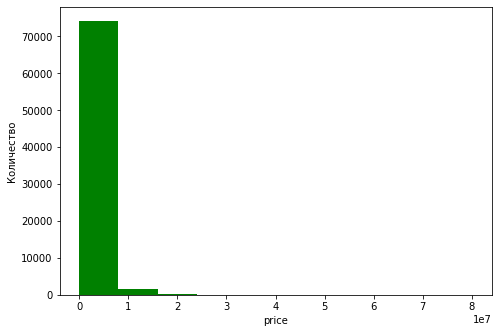

In [27]:
analysis_num_col(data,'price',3)

<AxesSubplot:>

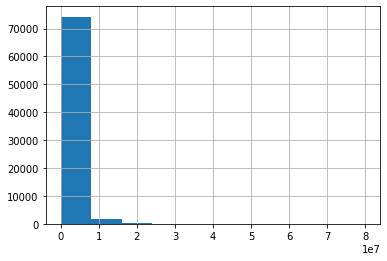

In [64]:
data['price'].hist(bins=10)

In [28]:
#Функция для анализа квантилей и выбросов
def analysis_quantile(df, col):   
    
    IQR = df[col].quantile(q=0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75), "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    
    # Подсчитаем количество выбросов
    print("Количество выбросов в столбце",col,":",df[df[col]<perc25 - 1.5*IQR][col].count() + df[df[col]>perc75 + 1.5*IQR][col].count())
    df[col].loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 20, label = 'IQR')
    plt.legend()  

25-й перцентиль: 889000.0, 75-й перцентиль: 2999000.0, IQR: 2110000.0,  Границы выбросов: [-2276000.0, 6164000.0].
Количество выбросов в столбце price : 2762


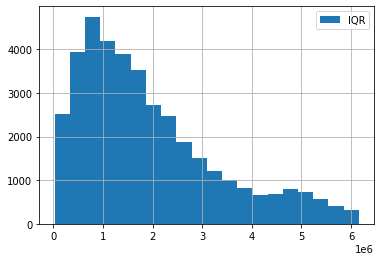

In [29]:
analysis_quantile(data[data['sample']==1],'price')

price
0.0           AxesSubplot(0.125,0.125;0.775x0.755)
25000.0       AxesSubplot(0.125,0.125;0.775x0.755)
27000.0       AxesSubplot(0.125,0.125;0.775x0.755)
30000.0       AxesSubplot(0.125,0.125;0.775x0.755)
35000.0       AxesSubplot(0.125,0.125;0.775x0.755)
                              ...                 
28790000.0    AxesSubplot(0.125,0.125;0.775x0.755)
29800000.0    AxesSubplot(0.125,0.125;0.775x0.755)
39990000.0    AxesSubplot(0.125,0.125;0.775x0.755)
50900000.0    AxesSubplot(0.125,0.125;0.775x0.755)
80000000.0    AxesSubplot(0.125,0.125;0.775x0.755)
Name: productionDate, Length: 8803, dtype: object

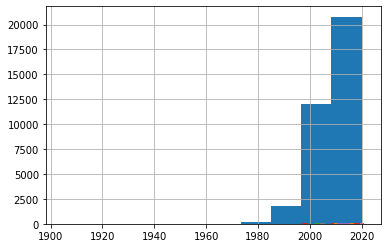

In [72]:
data.groupby('price')['productionDate'].hist()

In [30]:
#Заполнение модой там где NaN
def filling_mode(df, col): 
    df[col].fillna(df[col].mode()[0],inplace=True)

In [31]:
#Строим график для колонок, содержащих номинативные переменные
def get_boxplot(column, data):
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.boxplot(x=column, y='price', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

<AxesSubplot:xlabel='price'>

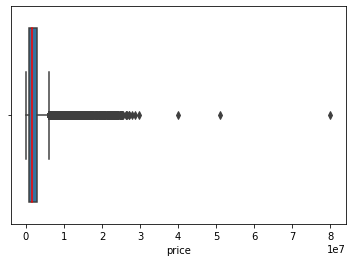

In [20]:
sns.boxplot(x=data[data['sample'] == 1]['price'], medianprops={'color':'red'})

 ### Рассмотрим и проанализируем колонку car_brand

<AxesSubplot:>

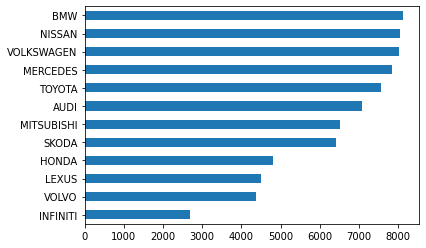

In [23]:
data['car_brand'].value_counts(ascending=True).plot(kind='barh')

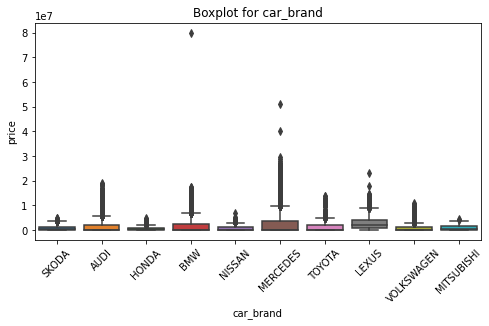

In [32]:
get_boxplot('car_brand',data)

Видны выбросы в цене

In [32]:
# заполняем пропуски в колонке имя модели (name_model) самым часто встречающимся типом в зависимости от бренда
data[data['car_brand'] == 'AUDI']['name_model'].value_counts().index[0]

'a6'

In [33]:
data.loc[(data['car_brand'] == 'AUDI','name_model')] = data[data['car_brand'] == 'AUDI']['name_model'].fillna(data[data['car_brand'] == 'AUDI']['name_model'].value_counts().index[0])
data.loc[(data['car_brand'] == 'SKODA','name_model')] = data[data['car_brand'] == 'SKODA']['name_model'].fillna(data[data['car_brand'] == 'SKODA']['name_model'].value_counts().index[0])
data.loc[(data['car_brand'] == 'MERCEDES','name_model')] = data[data['car_brand'] == 'MERCEDES']['name_model'].fillna(data[data['car_brand'] == 'MERCEDES']['name_model'].value_counts().index[0])
data.loc[(data['car_brand'] == 'TOYOTA','name_model')] = data[data['car_brand'] == 'TOYOTA']['name_model'].fillna(data[data['car_brand'] == 'TOYOTA']['name_model'].value_counts().index[0])
data.loc[(data['car_brand'] == 'LEXUS','name_model')] = data[data['car_brand'] == 'LEXUS']['name_model'].fillna(data[data['car_brand'] == 'LEXUS']['name_model'].value_counts().index[0])
data.loc[(data['car_brand'] == 'VOLKSWAGEN','name_model')] = data[data['car_brand'] == 'VOLKSWAGEN']['name_model'].fillna(data[data['car_brand'] == 'VOLKSWAGEN']['name_model'].value_counts().index[0])
data.loc[(data['car_brand'] == 'MITSUBISHI','name_model')] = data[data['car_brand'] == 'MITSUBISHI']['name_model'].fillna(data[data['car_brand'] == 'MERCEDES']['name_model'].value_counts().index[0])
data.loc[(data['car_brand'] == 'HONDA','name_model')] = data[data['car_brand'] == 'HONDA']['name_model'].fillna(data[data['car_brand'] == 'HONDA']['name_model'].value_counts().index[0])
data.loc[(data['car_brand'] == 'VOLVO','name_model')] = data[data['car_brand'] == 'VOLVO']['name_model'].fillna(data[data['car_brand'] == 'VOLVO']['name_model'].value_counts().index[0])
data.loc[(data['car_brand'] == 'BMW','name_model')] = data[data['car_brand'] == 'BMW']['name_model'].fillna(data[data['car_brand'] == 'BMW']['name_model'].value_counts().index[0])
data.loc[(data['car_brand'] == 'NISSAN','name_model')] = data[data['car_brand'] == 'NISSAN']['name_model'].fillna(data[data['car_brand'] == 'NISSAN']['name_model'].value_counts().index[0])
data.loc[(data['car_brand'] == 'INFINITI','name_model')] = data[data['car_brand'] == 'INFINITI']['name_model'].fillna(data[data['car_brand'] == 'INFINITI']['name_model'].value_counts().index[0])

In [34]:
data['name_model'].isnull().sum()

0

In [35]:
data=data.drop(['Unnamed: 0','Unnamed: 0.1'], axis = 1)

### ЗНАЧИМОСТЬ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Для оценки значимости категориальных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [55]:
#сначала закодировать
#imp_cat = Series(mutual_info_classif(data[cat_cols], data['price'],
#                                     discrete_features =True), index = cat_cols)
#imp_cat.sort_values(inplace = True)
#imp_cat.plot(kind = 'barh')

<AxesSubplot:>

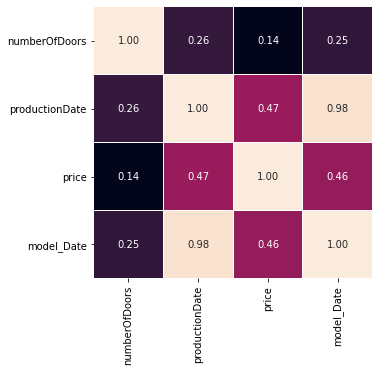

In [120]:
plt.rcParams['figure.figsize'] = (5,5)
sns.heatmap(data.drop(['sample','sell_id','name'], axis=1).corr(),annot=True, fmt=".2f", linewidths=0.1, cbar=False)

Мы видим хорошую корреляцию цены с productionDate и model_Date. Это логично, чем новее машина, тем она дороже.

## Создание полиномиальных признаков

In [36]:
#Создадим признаки на основе двух хорошо скоррелированных колонок production_Date и model_Date
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(data[['productionDate', 'model_Date']])
poly_features

array([[1.000000e+00, 2.014000e+03, 2.013000e+03, 4.056196e+06,
        4.054182e+06, 4.052169e+06],
       [1.000000e+00, 2.017000e+03, 2.017000e+03, 4.068289e+06,
        4.068289e+06, 4.068289e+06],
       [1.000000e+00, 2.014000e+03, 2.013000e+03, 4.056196e+06,
        4.054182e+06, 4.052169e+06],
       ...,
       [1.000000e+00, 2.007000e+03, 2.006000e+03, 4.028049e+06,
        4.026042e+06, 4.024036e+06],
       [1.000000e+00, 2.008000e+03, 2.006000e+03, 4.032064e+06,
        4.028048e+06, 4.024036e+06],
       [1.000000e+00, 2.010000e+03, 2.006000e+03, 4.040100e+06,
        4.032060e+06, 4.024036e+06]])

In [37]:
df = pd.DataFrame(poly_features,
                  columns = ['poly1', 'poly2', 'poly3','poly4','poly5','poly6']                  )
display(df)

,poly1,poly2,poly3,poly4,poly5,poly6
0,1.0,2014.0,2013.0,4056196.0,4054182.0,4052169.0
1,1.0,2017.0,2017.0,4068289.0,4068289.0,4068289.0
2,1.0,2014.0,2013.0,4056196.0,4054182.0,4052169.0
3,1.0,2014.0,2013.0,4056196.0,4054182.0,4052169.0
4,1.0,2012.0,2008.0,4048144.0,4040096.0,4032064.0
...,...,...,...,...,...,...
76010,1.0,2008.0,2007.0,4032064.0,4030056.0,4028049.0
76011,1.0,2007.0,2005.0,4028049.0,4024035.0,4020025.0
76012,1.0,2007.0,2006.0,4028049.0,4026042.0,4024036.0
76013,1.0,2008.0,2006.0,4032064.0,4028048.0,4024036.0


In [38]:
#Добавим наши признаки в наш дейтафрейм
data['poly1'] =df['poly1']
data['poly2'] =df['poly2']
data['poly3'] =df['poly3']
data['poly4'] =df['poly4']
data['poly5'] =df['poly5']
data['poly6'] =df['poly6']

На heatmap видим, как признаки связаны между собой и с целевой переменной.

<AxesSubplot:>

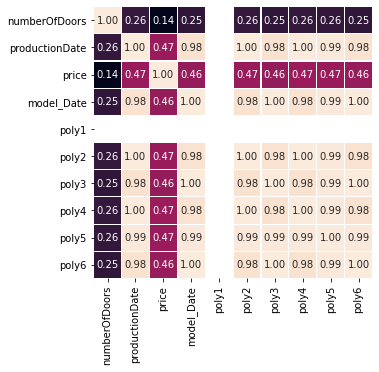

In [124]:
plt.rcParams['figure.figsize'] = (5,5)
sns.heatmap(data.drop(['sample','sell_id','name'], axis=1).corr(),annot=True, fmt=".2f", linewidths=0.1, cbar=False)

In [39]:
#Удалим количество дверей. Небольшая корреляция, можно убрать
data=data.drop(['numberOfDoors'], axis = 1)

In [40]:
data.columns

Index(['engineDisplacement', 'enginePower', 'model_name', 'name',
       'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'sample', 'price', 'model_Date', 'car_brand',
       'car_bodyType', 'car_color', 'car_fuelType', 'name_model', 'name_',
       'poly1', 'poly2', 'poly3', 'poly4', 'poly5', 'poly6'],
      dtype='object')

In [127]:
for col in cat_cols:
    get_stat_dif(col, data)

Найдены статистически значимые различия для колонки engineDisplacement
Найдены статистически значимые различия для колонки enginePower
Найдены статистически значимые различия для колонки name_
Найдены статистически значимые различия для колонки vehicleConfiguration
Найдены статистически значимые различия для колонки vehicleTransmission
Найдены статистически значимые различия для колонки car_brand
Найдены статистически значимые различия для колонки car_bodyType
Найдены статистически значимые различия для колонки car_fuelType
Найдены статистически значимые различия для колонки name_model


In [41]:
#Удалим лишние колонки
# model_name - старый необработанный вариант (name_model - оставим конечно как значимую)
# name - старый необработанный вариант мощности двигателя (name_ - оставим как значимую)
# productionDate и model_Date - на их основе построены полиноминальные признаки
# car_color
data=data.drop(['model_name','name','productionDate','model_Date','car_color'], axis = 1)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76015 entries, 0 to 76014
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   engineDisplacement    76015 non-null  object 
 1   enginePower           76015 non-null  object 
 2   sell_id               34686 non-null  float64
 3   vehicleConfiguration  76015 non-null  object 
 4   vehicleTransmission   76015 non-null  object 
 5   sample                76015 non-null  int64  
 6   price                 76015 non-null  float64
 7   car_brand             76015 non-null  object 
 8   car_bodyType          76015 non-null  object 
 9   car_fuelType          76015 non-null  object 
 10  name_model            76015 non-null  object 
 11  name_                 76015 non-null  object 
 12  poly1                 76015 non-null  float64
 13  poly2                 76015 non-null  float64
 14  poly3                 76015 non-null  float64
 15  poly4              

In [49]:
data.to_csv('./train_and_test.csv')

# Data Preprocessing

In [130]:
list_cat_columns = list(data.select_dtypes(include=['object']).columns)
list_cat_columns

['engineDisplacement',
 'enginePower',
 'vehicleConfiguration',
 'vehicleTransmission',
 'car_brand',
 'car_bodyType',
 'car_fuelType',
 'name_model',
 'name_']

In [131]:
for colum in list_cat_columns:
    data[colum] = data[colum].astype('category').cat.codes

In [132]:
data.sample(5)

,engineDisplacement,enginePower,sell_id,vehicleConfiguration,vehicleTransmission,sample,price,car_brand,car_bodyType,car_fuelType,name_model,name_,poly1,poly2,poly3,poly4,poly5,poly6
70765,13,40,NaN,160,1,1,2229000.0,7,1,0,306,147,1.0,2021.0,2017.0,4084441.0,4076357.0,4068289.0
58176,23,132,NaN,50,0,1,6459000.0,10,1,3,392,295,1.0,2019.0,2018.0,4076361.0,4074342.0,4072324.0
25257,9,311,1.090920e+09,539,2,0,0.0,10,24,0,175,59,1.0,1996.0,1991.0,3984016.0,3974036.0,3964081.0
36851,6,0,NaN,455,2,1,510000.0,2,24,0,200,36,1.0,2009.0,2008.0,4036081.0,4034072.0,4032064.0
24504,9,10,1.101220e+09,821,0,0,0.0,10,16,0,282,57,1.0,2017.0,2014.0,4068289.0,4062238.0,4056196.0


In [133]:
train_data = data.query('sample == 1').drop(['sample'], axis=1) 
test_data = data.query('sample == 0').drop(['sample'], axis=1)

In [134]:
train_data.shape, test_data.shape

((41329, 17), (34686, 17))

In [135]:
y = train_data.price.values            # наш таргет
#X = train_data[model_columns].values
X = train_data.drop(['price','sell_id'],axis=1).values

In [136]:
y.shape, X.shape

((41329,), (41329, 15))

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Модель 1. RandomForestRegressor

In [13]:
# Создаём модель
modelRF = RandomForestRegressor(n_estimators=300, verbose=1, n_jobs=-1, random_state=42)
modelRF.fit(X_train, y_train)
y_pred = modelRF.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.7s


MAE: 232941.74258475518
Точность модели по метрике MAPE: 12.89%


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.0s finished


<b>Точность наивной модели по метрике MAPE была 14.65%, а теперь после чистки данных и feature engineering: 12.89!</b> 

In [139]:
data.to_excel('./data_25n.xlsx')
data.to_csv('./data_25n.csv')

In [142]:
predict_submission = modelRF.predict(test_data.drop(['sell_id','price'],axis=1).values)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.4s finished


In [143]:
sample_submission = pd.read_csv('./sample_submission.csv')

In [146]:
sample_submission['price'] = predict_submission/1.4

In [148]:
sample_submission.to_csv('./sample_submission_25n.csv', index=False)

In [147]:
sample_submission.head()

,sell_id,price
0,1100575026,5.909536e+05
1,1100549428,8.926929e+05
2,1100658222,1.399255e+06
3,1100937408,5.739826e+05
4,1101037972,5.276397e+05
...,...,...
34681,1101369263,1.116237e+06
34682,1101369581,2.124010e+06
34683,1101364889,5.297873e+05
34684,1101362518,1.536071e+06


<b>На Kaggle на тестовой выборке результат - 24.28751! Baseline в 30.92228 преодален!</b>

In [6]:
data = pd.read_csv('./data_25n.csv')

In [7]:
data.head(5)

,Unnamed: 0,engineDisplacement,enginePower,sell_id,vehicleConfiguration,vehicleTransmission,sample,price,car_brand,car_bodyType,car_fuelType,name_model,name_,poly1,poly2,poly3,poly4,poly5,poly6
0,0,5,5,1.100575e+09,600,3,0,0.0,8,8,0,262,17,1.0,2014.0,2013.0,4056196.0,4054182.0,4052169.0
1,1,9,10,1.100549e+09,596,2,0,0.0,8,8,0,262,59,1.0,2017.0,2017.0,4068289.0,4068289.0,4068289.0
2,2,11,48,1.100658e+09,602,3,0,0.0,8,8,0,381,695,1.0,2014.0,2013.0,4056196.0,4054182.0,4052169.0
3,3,9,10,1.100937e+09,587,0,0,0.0,8,8,0,262,57,1.0,2014.0,2013.0,4056196.0,4054182.0,4052169.0
4,4,11,48,1.101038e+09,588,0,0,0.0,8,8,0,262,74,1.0,2012.0,2008.0,4048144.0,4040096.0,4032064.0


In [8]:
#train_data = data.query('sample == 1').drop(['sample'], axis=1) 
#test_data = data.query('sample == 0').drop(['sample'], axis=1)

#y = train_data.price.values            # наш таргет
#X = train_data.drop(['price','sell_id','Unnamed: 0'],axis=1).values

In [10]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [18]:
# Создаём модель
#modelRF = RandomForestRegressor(n_estimators=300, verbose=1, n_jobs=-1, random_state=42)
#modelRF.fit(X_train, y_train)
#y_pred = modelRF.predict(X_test)
#print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
#print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.0s


MAE: 232941.74258475518
Точность наивной модели по метрике MAPE: 12.89%


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


In [22]:
#predict_submission = modelRF.predict(test_data.drop(['sell_id','price','Unnamed: 0'],axis=1).values)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.4s finished


In [14]:
#sample_submission = pd.read_csv('./sample_submission.csv')

In [27]:
#sample_submission['price'] = predict_submission/1.3

In [28]:
#sample_submission.to_csv('./sample_submission_26n_1_3.csv', index=False)

### Модель RandomForestRegressor c логарифмированием целевой переменной

In [14]:
# Создаём модель
model_RF = RandomForestRegressor(n_estimators=300, verbose=1, n_jobs=-1, random_state=42)
model_RF.fit(X_train, np.log(y_train)) #логарифмируем y_train
y_pred = np.exp(model_RF.predict(X_test))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.6s


MAE: 230694.21914122504
Точность наивной модели по метрике MAPE: 12.04%


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    8.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished


In [17]:
predict_submission = np.exp(model_RF.predict(test_data.drop(['sell_id','price','Unnamed: 0'],axis=1).values))
sample_submission['price'] = predict_submission/1.3
sample_submission.to_csv('./sample_submission_26n_log_1_3.csv', index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished


<b>Логарифмирование дало на Kaggle MAPE = 19.39259! Это позволило сразу подняться на 28 пунктов в лидерборде</b>

# Модель 2. DecisionTreeRegressor

In [14]:
clf = DecisionTreeRegressor(max_depth=11, random_state=42)#max_features = 2
clf.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=11, random_state=42)

In [15]:
y_pred = clf.predict(X_test) #предсказываем на тестовой выборке
#считаем значения метрики  
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 15.45%


In [16]:
#Глубина дерева
clf.get_depth()

11

С логарифмированием:

In [18]:
clf.fit(X_train,np.log(y_train))
y_pred = np.exp(clf.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 14.38%


# Модель 3. LinearRegression

In [20]:
#без логарифмирования
LR = LinearRegression()
lr_model = LR.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 97.49%


In [19]:
#с логарифмированием
LR = LinearRegression()
lr_model = LR.fit(X_train, np.log(y_train))
y_pred = np.exp(lr_model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 27.54%


# Модель 4. CatBoost

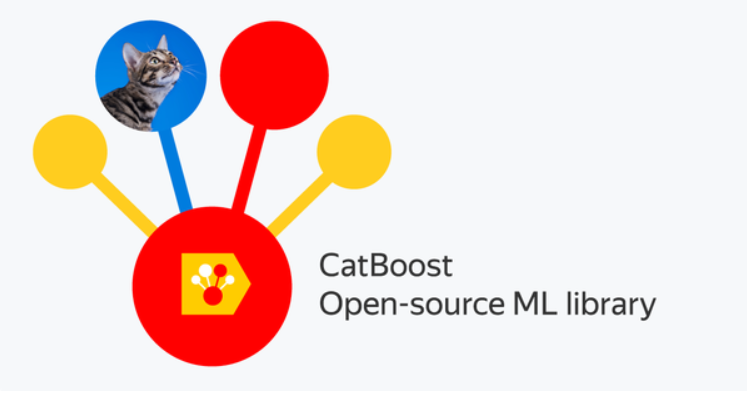

Запускала ее Kaggle, так как не установила пока на компьютер. У меня 32 разрядный Питон, а для установки требуется 64 разрядный.

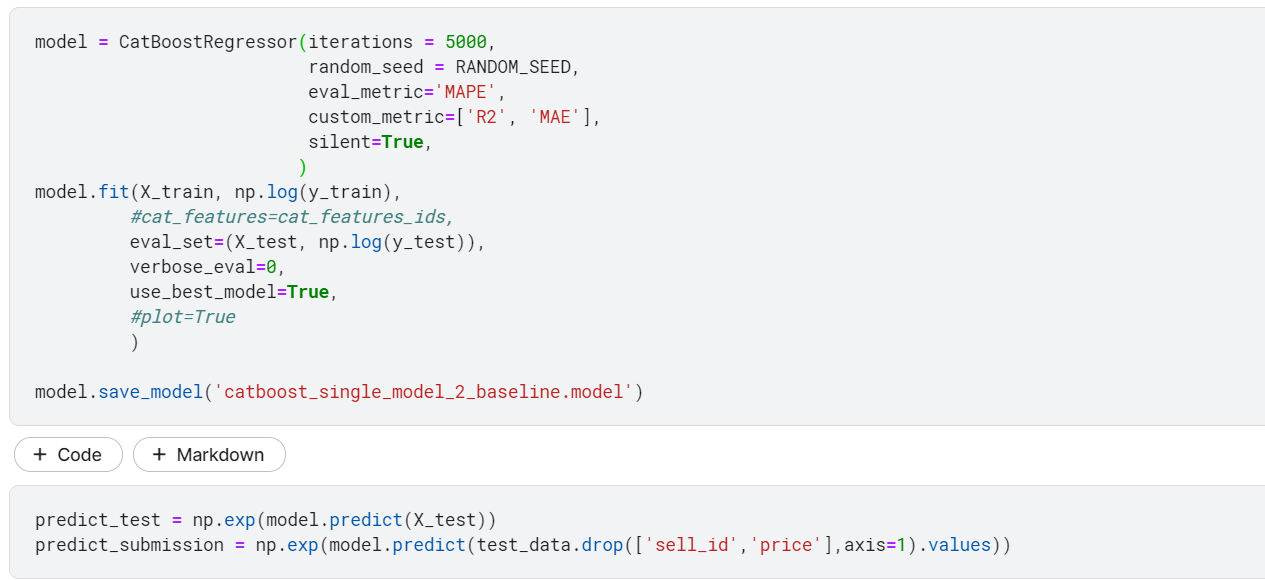

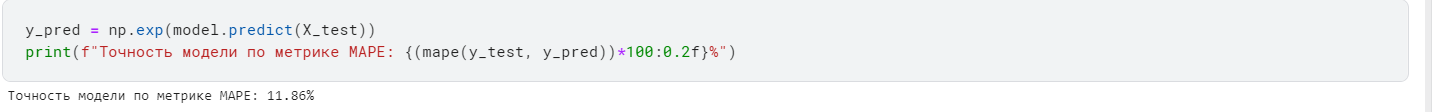

<b>Проголарифмировала целевую переменную и получила на Kaggle MAPE = 18.90026! Пока это лучший вариант</b>

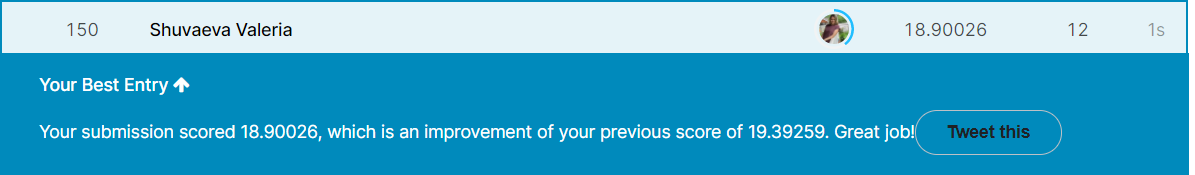

<b>Зададим сетку гиперпараметров, которые будут перебираться:</b>

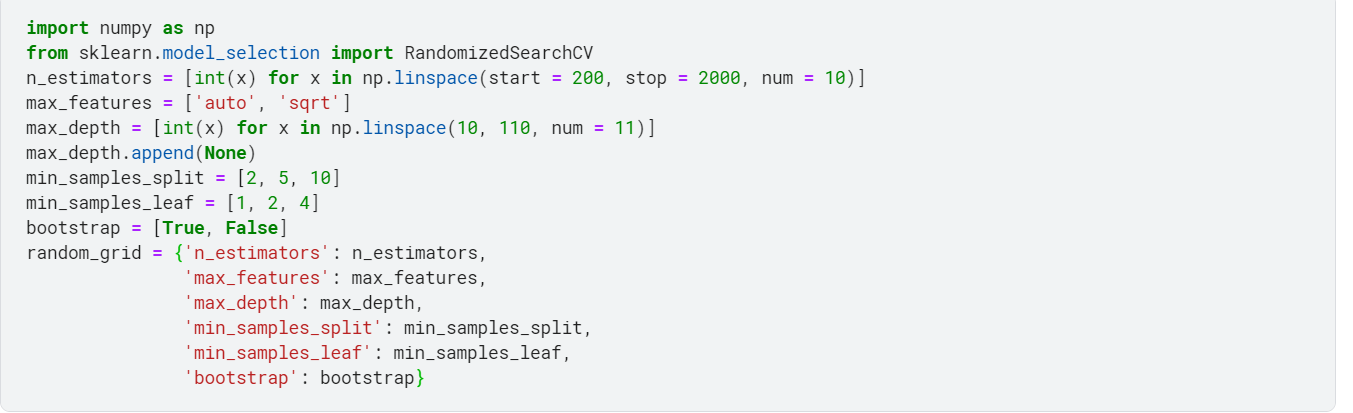

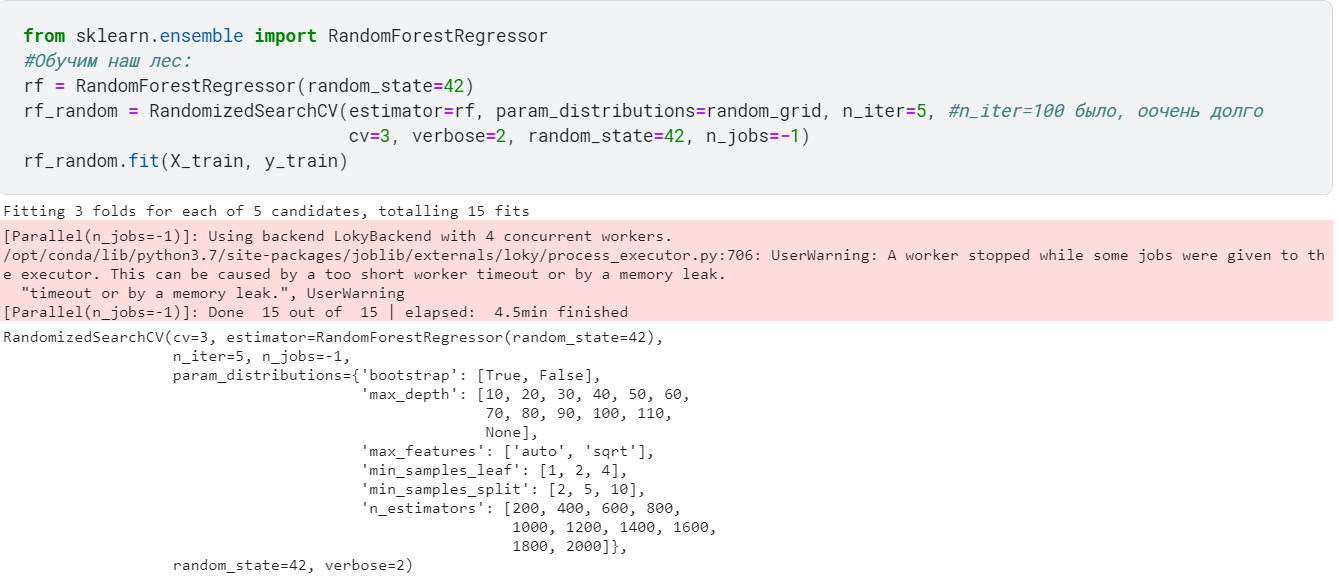

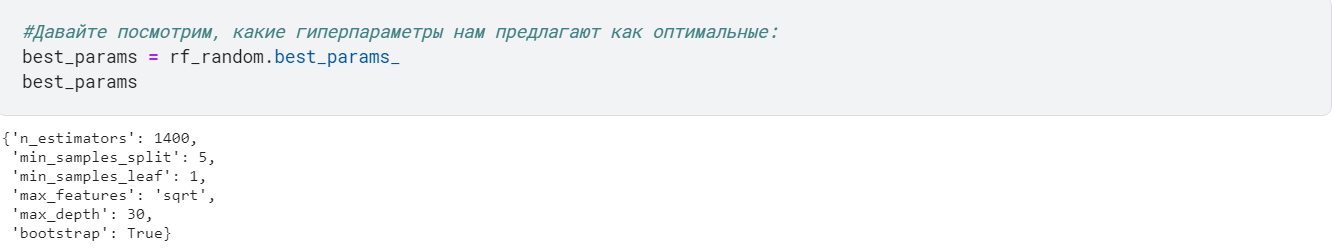

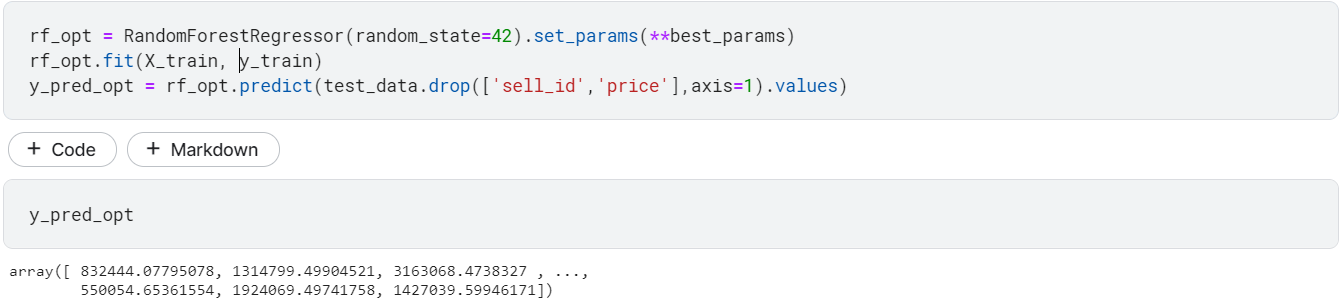

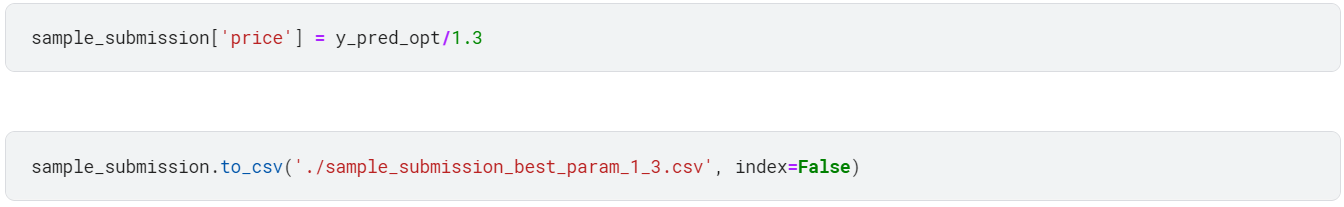

<b>На Kaggle это дало score (24.41107) намного хуже, чем был </b>

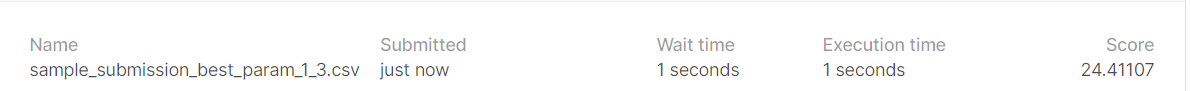

<b>Запущу с теми же best_param, но с логарифмированием переменной</b>

In [21]:
rf_opt = RandomForestRegressor(n_estimators=1400, min_samples_split=5,min_samples_leaf=1,max_features='sqrt',max_depth=30,bootstrap=True,random_state=42)

In [22]:
rf_opt.fit(X_train, np.log(y_train))
y_pred = np.exp(rf_opt.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 11.90%


In [15]:
predict_submission = np.exp(rf_opt.predict(test_data.drop(['sell_id','price','Unnamed: 0'],axis=1).values))
sample_submission['price'] = predict_submission/1.3
sample_submission.to_csv('./sample_submission_26n_rf_opt_log_1_3.csv', index=False)

<b>Проголарифмировала целевую переменную в модели RandomForestRegressor с лучшими параметрами, найденными RandomizedSearchCV  и получила Score = 18.35856!</b>

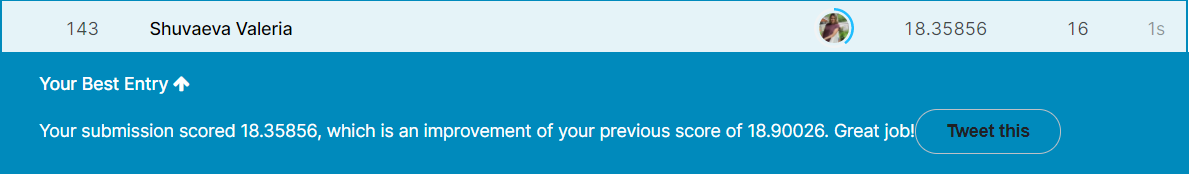

<b>Попробую нормализовать данные с помощью StandardScaler</b>

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

In [21]:
rf_opt.fit(X_train, np.log(y_train))
y_pred = np.exp(rf_opt.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 11.90%


<b>Результат не стал лучше</b>

# Модель 5. KNeighborsRegressor

In [50]:
Knn = KNeighborsRegressor(n_neighbors=10, weights='distance', algorithm='ball_tree', p=1)

In [51]:
Knn_model = Knn.fit(X_train, np.log(y_train))
y_pred = np.exp(Knn_model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 13.06%


# Модель 6. GradientBoostingRegressor

In [56]:
GBR = GradientBoostingRegressor(n_estimators=600, loss='huber', random_state=42, learning_rate=0.4)
GBR_model = GBR.fit(X_train, np.log(y_train))
y_pred = np.exp(GBR_model.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 12.17%


## Стекинг

In [59]:
cv = KFold(n_splits=5, shuffle=True,random_state=42)
estimators = [('DTR', DecisionTreeRegressor(max_depth=11, random_state=42)),
              ('LR', LinearRegression()),
              ('CB', CatBoostRegressor(iterations = 5000,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True)),
              ('KNR', KNeighborsRegressor(n_neighbors=10,
                                          weights='distance',
                                          algorithm='ball_tree',p=1)),
              ('GBR', GradientBoostingRegressor(n_estimators=600,
                                                loss='huber',
                                                random_state=42,
                                                learning_rate=0.4)),
 
             ]
final_estimator = RandomForestRegressor(n_estimators=1400,
                                        min_samples_split=5,
                                        min_samples_leaf=1,
                                        max_features='sqrt',
                                        max_depth=30,
                                        bootstrap=True,
                                        random_state=42)

StR = StackingRegressor(estimators=estimators,
                        final_estimator=final_estimator,
                        cv=cv,
                        n_jobs=-1,
                        passthrough=True)


In [61]:
StR.fit(X_train, np.log(y_train))
y_pred = np.exp(StR.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

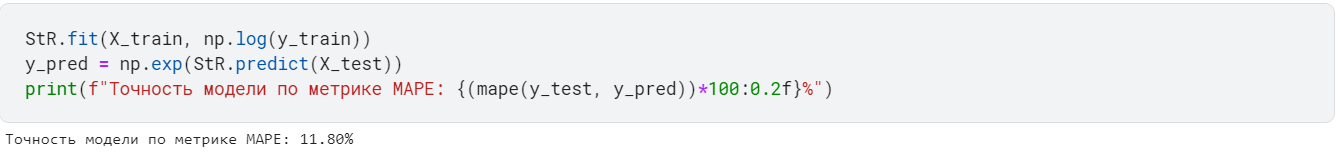

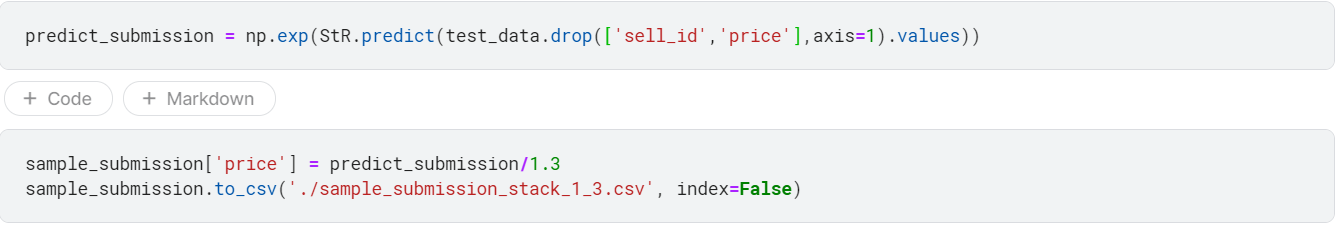

На Kaggle это дало - 18.67126. А это все же хуже лучшего результата

Уберу часть моделей, у которых были не лучшие показатели.

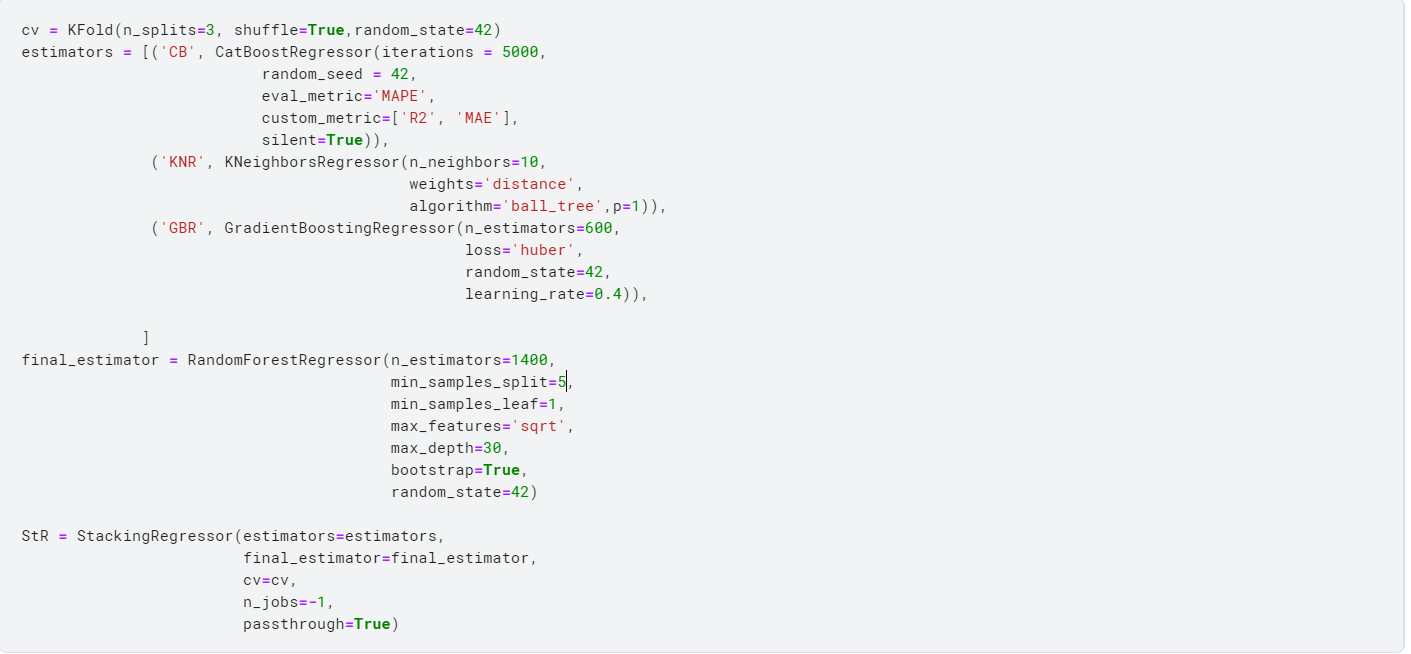

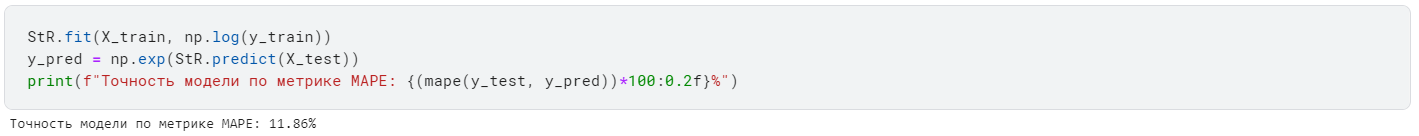

Точность 11.86 хуже той, что получилась при стакинге всех моделей

Попробуем найти лучшие параметры для модели DecisionTreeRegressor

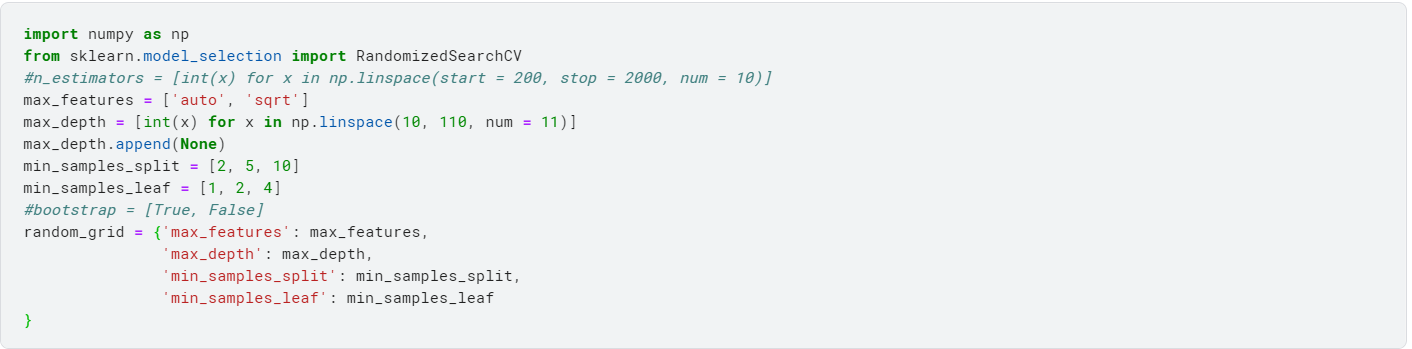

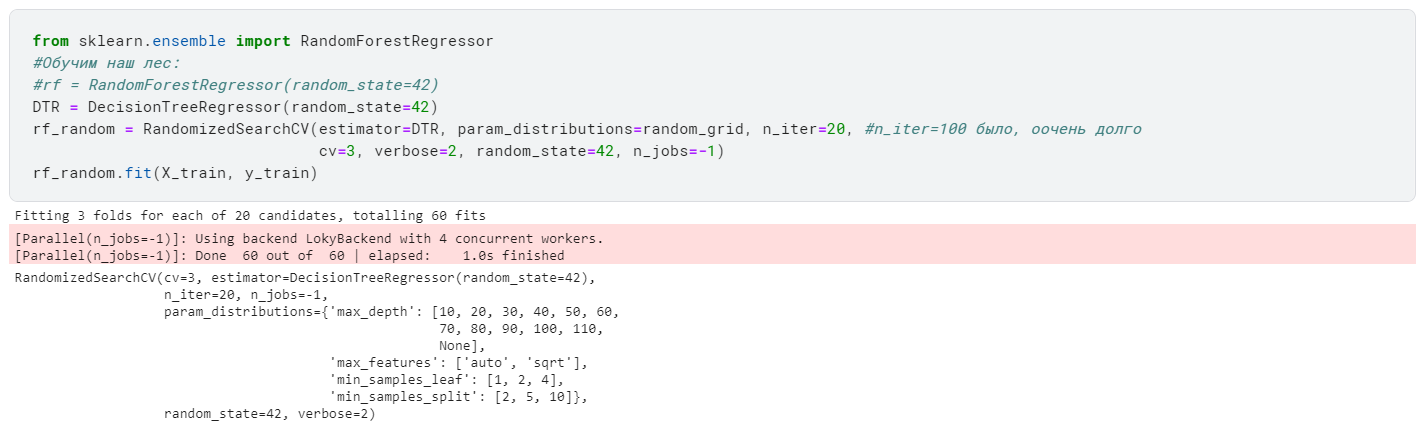

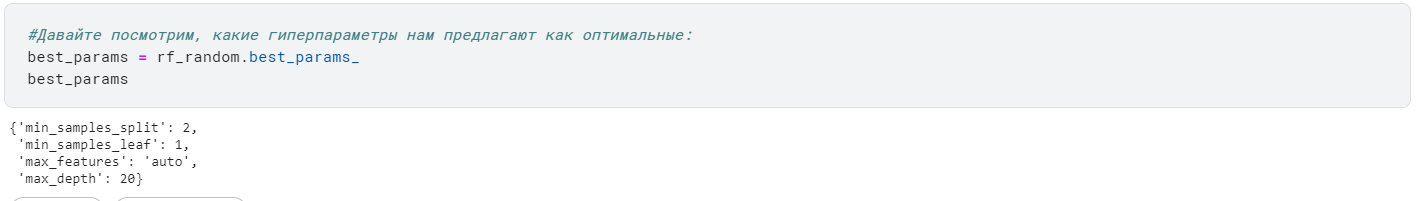

In [62]:
DTR = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=1, max_features='auto', max_depth=20, random_state=42)
DTR.fit(X_train,np.log(y_train))
y_pred = np.exp(DTR.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

Точность модели по метрике MAPE: 13.51%


13.51 лучше, чем 14.38 без подбора параметров

<b>Запущу 4 модели в стекинг c добавлением DecisionTreeRegression с улучшенными параметрами</b>

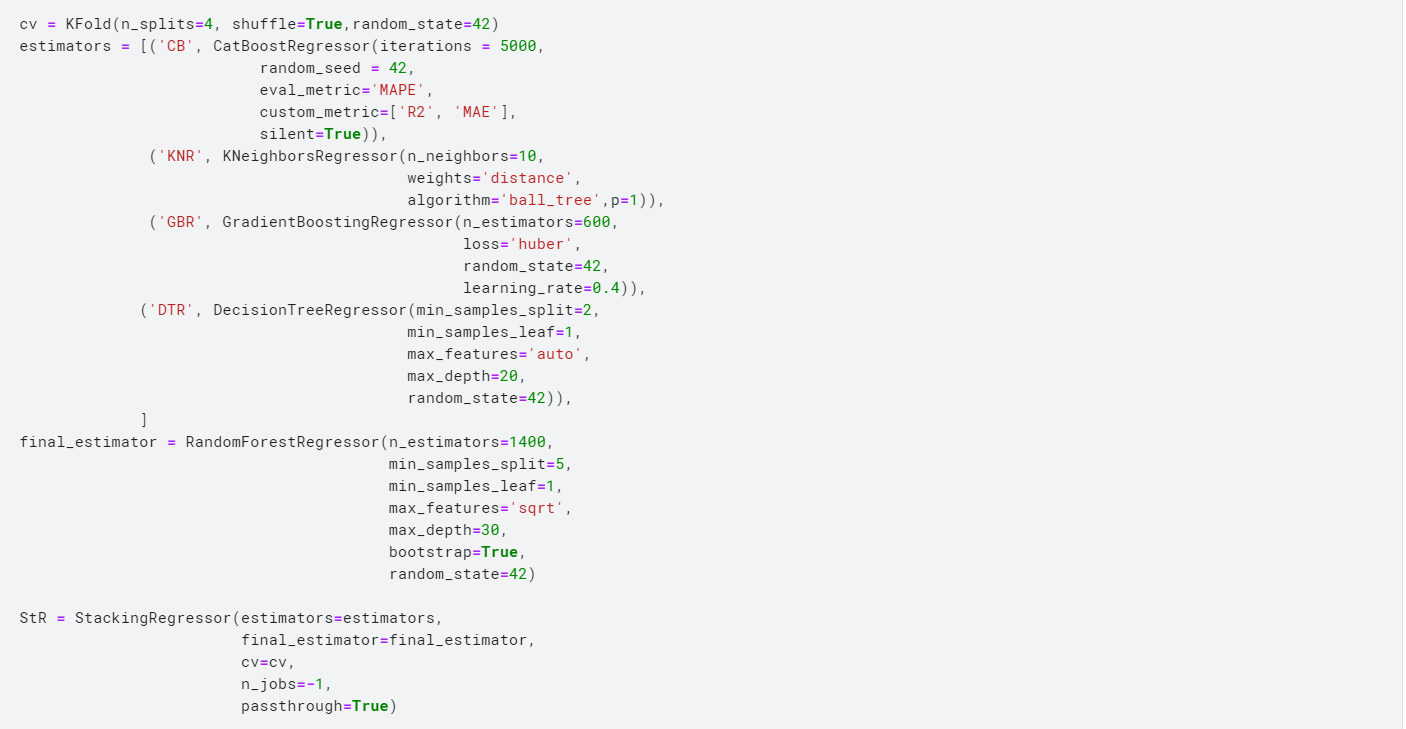

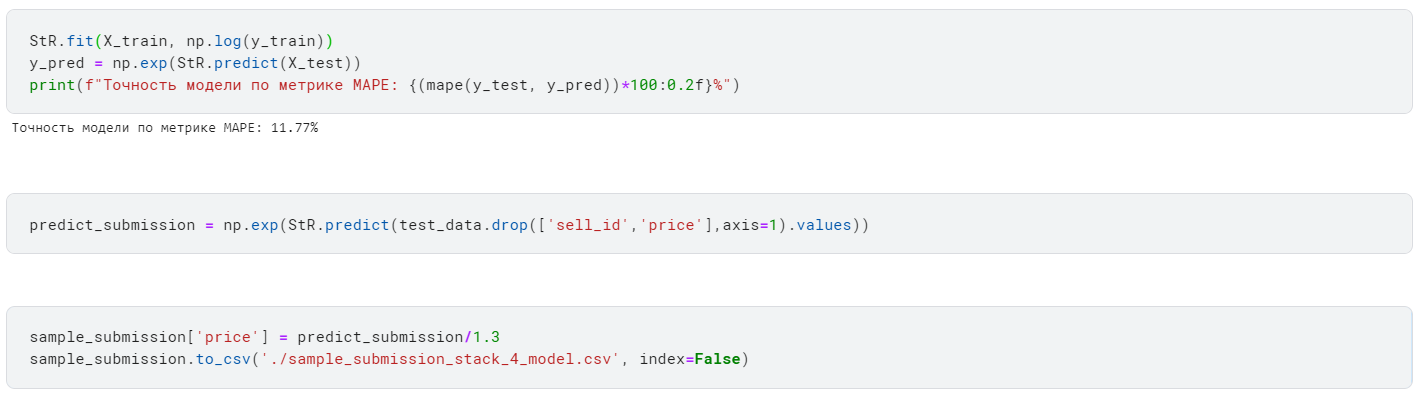

Получилось MAPE = 11,77! Это лучший вариант. Но при загрузки этого сабмита на Kaggle Score = 18.56191

<b>Он все равно хуже, чем MAPE = 18.35856, который расчитан RandomForestRegressor с лучшими параметрами, найденными RandomizedSearchCV</b>

In [32]:
data = pd.read_csv('./data_25n.csv')

Попробую убрать выбросы из базы до ее кодировки.

In [33]:
data.columns

Index(['Unnamed: 0', 'engineDisplacement', 'enginePower', 'sell_id',
       'vehicleConfiguration', 'vehicleTransmission', 'sample', 'price',
       'car_brand', 'car_bodyType', 'car_fuelType', 'name_model', 'name_',
       'poly1', 'poly2', 'poly3', 'poly4', 'poly5', 'poly6'],
      dtype='object')

25-й перцентиль: 40.0, 75-й перцентиль: 132.0, IQR: 92.0,  Границы выбросов: [-98.0, 270.0].
Количество выбросов в столбце enginePower : 5706


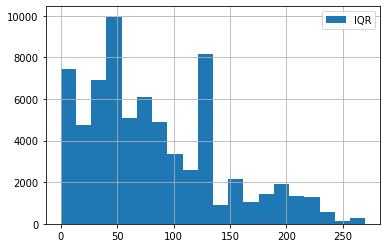

In [34]:
func_quantile(data, 'enginePower')

In [35]:
filling_quantile(data, 'enginePower', 0.75)

25-й перцентиль: 40.0, 75-й перцентиль: 132.0, IQR: 92.0,  Границы выбросов: [-98.0, 270.0].
Количество выбросов в столбце enginePower : 0


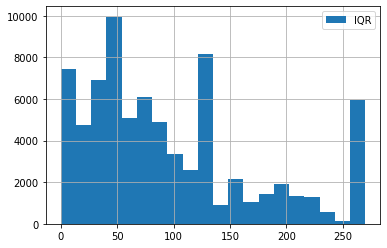

In [36]:
func_quantile(data, 'enginePower')

25-й перцентиль: 11.0, 75-й перцентиль: 23.0, IQR: 12.0,  Границы выбросов: [-7.0, 41.0].
Количество выбросов в столбце engineDisplacement : 2089


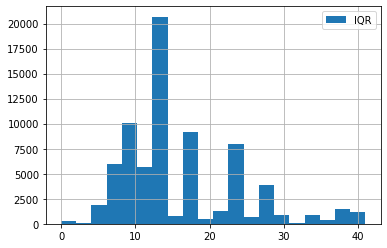

In [37]:
func_quantile(data, 'engineDisplacement')

In [38]:
filling_quantile(data, 'engineDisplacement', 0.75)

25-й перцентиль: 11.0, 75-й перцентиль: 23.0, IQR: 12.0,  Границы выбросов: [-7.0, 41.0].
Количество выбросов в столбце engineDisplacement : 0


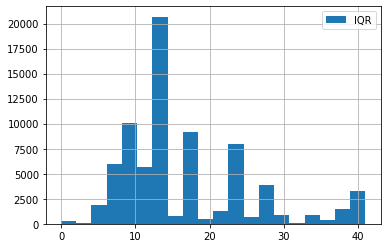

In [39]:
func_quantile(data, 'engineDisplacement')

In [40]:
data.to_csv('./data.csv', index=False)

In [19]:
list_cat_columns = list(data.select_dtypes(include=['object']).columns)

for colum in list_cat_columns:
    data[colum] = data[colum].astype('category').cat.codes
train_data = data.query('sample == 1').drop(['sample'], axis=1) 
test_data = data.query('sample == 0').drop(['sample'], axis=1)
y = train_data.price.values
X = train_data.drop(['price','sell_id'],axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)


In [20]:
rf_opt = RandomForestRegressor(n_estimators=1400, min_samples_split=5,min_samples_leaf=1,max_features='sqrt',max_depth=30,bootstrap=True,random_state=42)

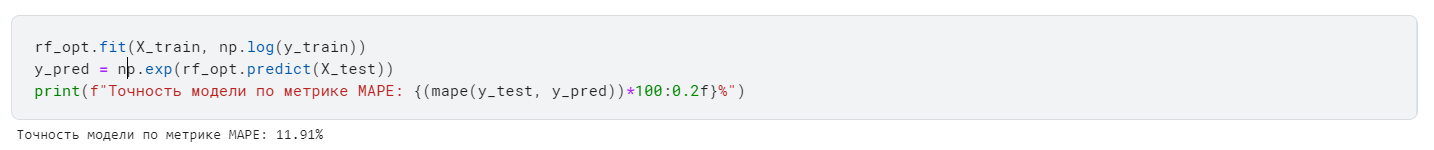

Запустила на Kaggle расчет, тут не хватило памяти. Результат MAPE особо не поменялся.

# Заключение

Значение метрики на тестовых данных (на Kaggle) составило 18.35856.
Предположительно, уменьшение значения MAPE можно было бы достичь следующими способами:

- более глубокое изучение имеющихся признаков. Сгруппировать некоторые признаки в пределах колонки по определенным критериям (сделать признак по годам по периоду десять лет или сгруппировать типы двигателей), сделать кодирование категориальных признаков через dummy-переменные, а не через cat.codes   
- настройка гиперпараметров для каждой модели из стекинга, а не только для RandomForestRegressor и DecisionTreeRegressor
- обучение моделей на большем количестве спарсенных данных. На каждой странице сайта было примерно по 37 объявлений на 80-99 страницах каждой модели. Это не дало нужного объема Train (41329) vs Test (34686). Трейн должны быть в 4 раза больше тестовых данных, но столько набрать не получилось. Можно было бы набрать еще машин других брендов и обучить на всем объеме. 